In [203]:
import boto3
import config as CONFIG
import pandas as pd
from sklearn.preprocessing import Normalizer, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
import os
import numpy as np

from pytz import timezone
import datetime as dt

import warnings
import random

from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten

# Tắt cảnh báo
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# In[2]

TRAIN_DIR = './24_06_IS_HOT_TOMTOM/TRAIN_DATA/'
TEST_DIR = './24_06_IS_HOT_TOMTOM/TEST_DATA/'


def processing_data(data_dir):
    # TRAIN_DIR = os.path.join('.', 'is_hot_tomtom_segment_status3')
    csv_file_list = os.listdir(data_dir)
    total_df = pd.DataFrame()
    for csv_file in csv_file_list:
        temp_df = pd.read_csv(os.path.join(data_dir, csv_file), index_col=0)
        total_df = pd.concat([total_df, temp_df])

    label_encoder = LabelEncoder()
    total_df['base_LOS']= label_encoder.fit_transform(total_df['base_LOS'])
    total_df['isHot'] = label_encoder.fit_transform(total_df['isHot'])
    total_df['weather'] = label_encoder.fit_transform(total_df['weather'])

    return total_df

def get_period_df(parameters, total_df):
    period_df = total_df.copy()
    for key, value in parameters.items():
        if value is not None:
            period_df = period_df.loc[period_df[key].isin(value)]
    return period_df

In [204]:
total_df = processing_data(TRAIN_DIR)
test_df = processing_data(TEST_DIR)

In [205]:
test_df.head(5)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration_velocity,duration_LOS
0,period_19_00,23795,2023-06-09,4,26,2,0,0,27,Quận Gò Vấp,10.830985,106.677322,0,1,1
1,period_19_00,60703,2023-06-09,4,26,2,0,0,27,Quận Gò Vấp,10.831059,106.677386,0,1,1
2,period_19_00,23794,2023-06-09,4,26,2,0,0,27,Quận Gò Vấp,10.830916,106.677520,0,1,1
3,period_19_00,60704,2023-06-09,4,26,2,0,0,27,Quận Gò Vấp,10.830894,106.677499,0,1,1
4,period_19_00,60538,2023-06-09,4,26,2,0,0,27,Quận Gò Vấp,10.830924,106.677335,0,1,1


In [206]:
def processing_data2(period_df, cluster_colums = ['tomtom_velocity', 'duration_velocity']):
    period_df_time = period_df.copy()
    for column_item in period_df_time.columns:
        if column_item not in cluster_colums:
            period_df_time.drop([column_item], axis=1, inplace = True)
    return period_df_time

## LSTM

In [221]:
# Hàm hỗ trợ tạo dữ liệu theo cửa sổ trượt
def create_sliding_window(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size), :]
        X.append(window)
        Y.append(data[i + window_size, :])
    return np.array(X), np.array(Y)


In [215]:
def train_test_split_func(data_X, data_Y):
    train_ratio = 0.7
    train_size = int(len(data_X) * train_ratio)
    
    train_X, test_X = data_X[:train_size], data_X[train_size:]
    train_Y, test_Y = data_Y[:train_size], data_Y[train_size:]
    
    return train_X, test_X, train_Y, test_Y
    

In [245]:
def get_traning_test_data(data_df, seg_id_item):
#     # Tại một quận cụ thể
#     parameters = {
#         "period": ["period_16_55"],
#         "weekday": [1],
#         "district": ["Thành phố Thủ Đức"],
#     #     "is_morning": [1]
#     }
#     period_df = get_period_df(parameters, data_df)
    
    train_df = pd.DataFrame([])
    temp_seg_df = data_df.loc[data_df.segment_id == seg_id_item].copy()

    scaler = MinMaxScaler(feature_range=(0, 1))
    temp_seg_df[['tomtom_velocity', 'duration_velocity']] = scaler.fit_transform(temp_seg_df[['tomtom_velocity', 'duration_velocity']])
    train_X, train_Y = [], []
    test_X, test_Y = [], []
    for date_item in temp_seg_df.date.unique():
        temp_date_df = temp_seg_df.loc[temp_seg_df.date == date_item]
        for is_morning_item in temp_date_df.is_morning.unique():
            temp_df = temp_date_df.loc[temp_date_df.is_morning == is_morning_item]
            if temp_df.shape[0] == 0:
                continue
            train_df = processing_data2(temp_df)
            train_df = np.array(train_df)
            temp_X, temp_Y = create_sliding_window(train_df, 10)

            temp_train_X, temp_test_X, temp_train_Y, temp_test_Y = train_test_split_func(temp_X, temp_Y)

            if len(train_X) == 0:
                train_X = temp_train_X
                train_Y = temp_train_Y

                test_X = temp_test_X
                test_Y = temp_test_Y          

            else:
                train_X = np.concatenate((train_X, temp_train_X), axis = 0)
                train_Y = np.concatenate((train_Y, temp_train_Y), axis = 0)

                test_X = np.concatenate((test_X, temp_test_X), axis = 0)
                test_Y = np.concatenate((test_Y, temp_test_Y), axis = 0) 
                
    return train_X, train_Y, test_X, test_Y
    

In [246]:
def get_traning_test_data2(data_df, seg_id_item):
#     # Tại một quận cụ thể
#     parameters = {
#         "period": ["period_16_55"],
#         "weekday": [1],
#         "district": ["Thành phố Thủ Đức"],
#     #     "is_morning": [1]
#     }
#     period_df = get_period_df(parameters, data_df)
    
    train_df = pd.DataFrame([])
    temp_seg_df = data_df.loc[data_df.segment_id == seg_id_item].copy()

    scaler = MinMaxScaler(feature_range=(0, 1))
    temp_seg_df[['tomtom_velocity', 'duration_velocity']] = scaler.fit_transform(temp_seg_df[['tomtom_velocity', 'duration_velocity']])
    train_X, train_Y = [], []
    for date_item in temp_seg_df.date.unique():
        temp_date_df = temp_seg_df.loc[temp_seg_df.date == date_item]
        for is_morning_item in temp_date_df.is_morning.unique():
            temp_df = temp_date_df.loc[temp_date_df.is_morning == is_morning_item]
            if temp_df.shape[0] == 0:
                continue
            train_df = processing_data2(temp_df)
            train_df = np.array(train_df)
            temp_train_X, temp_train_Y = create_sliding_window(train_df, 10)

            if len(train_X) == 0:
                train_X = temp_train_X
                train_Y = temp_train_Y       

            else:
                train_X = np.concatenate((train_X, temp_train_X), axis = 0)
                train_Y = np.concatenate((train_Y, temp_train_Y), axis = 0)
                
    return train_X, train_Y

In [ ]:
a, b = get_traning_test_data2(test_df, )

In [236]:
def create_multi_output_model(out_size = 2):
    # Xây dựng mô hình hỗn hợp
    model = Sequential()
    model.add(LSTM(50, input_shape=(window_size, out_size))) #train_X.shape[2] = out_size
    model.add(Dense(50, activation='relu'))
    model.add(Dense(out_size))  # Số lượng đầu ra bằng số lượng thuộc tính (ở đây là 3)
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [237]:
def create_hybrid_model(out_size = 2):
    model = Sequential()
    model.add(LSTM(50, input_shape=(window_size, out_size))) #train_X.shape[2] = out_size
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(out_size))  
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [238]:
seg_id_item = 23795
train_X, train_Y, test_X, test_Y = get_traning_test_data(total_df, seg_id_item)

In [239]:
multi_output_model = create_multi_output_model(train_X.shape[2])

In [240]:
# Huấn luyện mô hình
multi_output_model.fit(train_X, train_Y, epochs=10, batch_size=16)

Epoch 1/10
105/105 [==============================] - 1s 2ms/step - loss: 0.0121
Epoch 2/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 3/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 4/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 5/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 6/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 7/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 8/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 9/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 10/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0058


In [247]:
# Đánh giá mô hình trên tập kiểm tra
train_loss = model.evaluate(train_X, train_Y, verbose=0)
print('Train loss:', train_loss)
test_loss = model.evaluate(test_X, test_Y, verbose=0)
print('Test loss:', test_loss)

Train loss: 0.005771576426923275
Test loss: 0.007425240706652403


In [249]:
val_X, val_Y = get_traning_test_data2(test_df, seg_id_item)

In [250]:
test_loss2 = model.evaluate(val_X, val_Y, verbose=0)
print('Test loss2:', test_loss2)

Test loss2: 0.01703795976936817


In [253]:
segment_list = test_df.segment_id.unique()

In [254]:
print(len(segment_list))

531


In [210]:


# Tại một quận cụ thể
parameters = {
    "period": ["period_16_55"],
    "weekday": [1],
    "district": ["Thành phố Thủ Đức"],
#     "is_morning": [1]
}
period_df = get_period_df(parameters, total_df)
# Chuẩn bị dữ liệu giao thông (bao gồm nhiều thuộc tính)
traffic_data = processing_data2(period_df)  # Danh sách các dữ liệu giao thông (bao gồm nhiều thuộc tính)
traffic_data = np.array(traffic_data)


In [211]:
total_df.head(5)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration_velocity,duration_LOS
0,period_19_00,23795,2023-05-13,5,23,3,0,0,27,Quận Gò Vấp,10.830985,106.677322,0,1,1
1,period_19_00,60703,2023-05-13,5,23,3,0,0,27,Quận Gò Vấp,10.831059,106.677386,0,1,1
2,period_19_00,23794,2023-05-13,5,23,3,0,0,27,Quận Gò Vấp,10.830916,106.677520,0,1,1
3,period_19_00,60704,2023-05-13,5,23,3,0,0,27,Quận Gò Vấp,10.830894,106.677499,0,1,1
4,period_19_00,60538,2023-05-13,5,23,3,0,0,27,Quận Gò Vấp,10.830924,106.677335,0,1,1


In [212]:
import random
from sklearn.model_selection import train_test_split

# Dữ liệu mẫu
X = [[1, 3], [2, 1], [3, 10], [4, 6], [5, 1]]
X2 = [[1, 4], [4, 4]]
D = X + X2
print(D)
Y = ['a', 'b', 'c', 'd', 'e']

# Kết hợp thành cặp dữ liệu
data = list(zip(X, Y))

# Shuffle dữ liệu
random.shuffle(data)

# Tách thành tập training và testing
train_data, test_data = train_test_split(data, test_size=0.3)


# In kết quả
print("Training data:")
for pair in train_data:
    print(pair)

print("\nTesting data:")
for pair in test_data:
    print(pair)


[[1, 3], [2, 1], [3, 10], [4, 6], [5, 1], [1, 4], [4, 4]]
Training data:
([2, 1], 'b')
([4, 6], 'd')
([1, 3], 'a')

Testing data:
([3, 10], 'c')
([5, 1], 'e')


In [213]:
import random
from sklearn.model_selection import train_test_split
import numpy as np

# Dữ liệu mẫu
X = [1, 2, 3, 4, 5]
Y = ['a', 'b', 'c', 'd', 'e']

# Kết hợp thành cặp dữ liệu
data = list(zip(X, Y))

# Shuffle dữ liệu
random.shuffle(data)

# Tách thành tập training và testing
train_data, test_data = train_test_split(data, test_size=0.3)

# Chuyển đổi thành mảng
train_data = np.array(train_data)
test_data = np.array(test_data)

# In kết quả
print("Training data:")
print(train_data)

print("\nTesting data:")
print(test_data)


Training data:
[['5' 'e']
 ['2' 'b']
 ['1' 'a']]

Testing data:
[['3' 'c']
 ['4' 'd']]


In [216]:
seg_id_item = 23795

In [217]:
train_df = pd.DataFrame([])
temp_seg_df = total_df.loc[total_df.segment_id == seg_id_item].copy()

scaler = MinMaxScaler(feature_range=(0, 1))
temp_seg_df[['tomtom_velocity', 'duration_velocity']] = scaler.fit_transform(temp_seg_df[['tomtom_velocity', 'duration_velocity']])
train_X, train_Y = [], []
test_X, test_Y = [], []
for date_item in temp_seg_df.date.unique():
    temp_date_df = temp_seg_df.loc[temp_seg_df.date == date_item]
    for is_morning_item in temp_date_df.is_morning.unique():
        temp_df = temp_date_df.loc[temp_date_df.is_morning == is_morning_item]
        if temp_df.shape[0] == 0:
            continue
        train_df = processing_data2(temp_df)
        train_df = np.array(train_df)
        temp_X, temp_Y = create_sliding_window2(train_df, 10)
        
        temp_train_X, temp_test_X, temp_train_Y, temp_test_Y = train_test_split_func(temp_X, temp_Y)
        
        if len(train_X) == 0:
            train_X = temp_train_X
            train_Y = temp_train_Y
            
            test_X = temp_test_X
            test_Y = temp_test_Y          
            
        else:
            train_X = np.concatenate((train_X, temp_train_X), axis = 0)
            train_Y = np.concatenate((train_Y, temp_train_Y), axis = 0)
            
            test_X = np.concatenate((test_X, temp_test_X), axis = 0)
            test_Y = np.concatenate((test_Y, temp_test_Y), axis = 0) 

        
        

In [218]:
# Xây dựng mô hình hỗn hợp
model = Sequential()
model.add(LSTM(50, input_shape=(window_size, train_X.shape[2])))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(train_X.shape[2]))  # Số lượng đầu ra bằng số lượng thuộc tính (ở đây là 3)
model.compile(loss='mean_squared_error', optimizer='adam')

In [219]:
# Huấn luyện mô hình
model.fit(train_X, train_Y, epochs=10, batch_size=16)

Epoch 1/10
105/105 [==============================] - 1s 2ms/step - loss: 0.0091
Epoch 2/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 3/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 4/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 5/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 6/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 7/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 8/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 9/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 10/10
105/105 [==============================] - 0s 2ms/step - loss: 0.0058


In [220]:
# Đánh giá mô hình trên tập kiểm tra
train_loss = model.evaluate(train_X, train_Y, verbose=0)
print('Train loss:', train_loss)
test_loss = model.evaluate(test_X, test_Y, verbose=0)
print('Test loss:', test_loss)

Train loss: 0.005771576426923275
Test loss: 0.007425240706652403


In [165]:
import random
import numpy as np

# Dữ liệu mẫu
X = np.array([1, 2, 3, 4, 5])
Y = np.array(['a', 'b', 'c', 'd', 'e'])

# Kết hợp thành cặp dữ liệu
data = np.array(list(zip(X, Y)))

# Shuffle dữ liệu
random.shuffle(data)

# Chia thành tập training và testing
train_ratio = 0.7
train_size = int(len(data) * train_ratio)

train_data = data[:train_size]
test_data = data[train_size:]

# In kết quả
print("Training data:")
print(type(train_data))

print("\nTesting data:")
print(test_data)


Training data:
<class 'numpy.ndarray'>

Testing data:
[['3' 'c']
 ['3' 'c']]


In [46]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Hàm hỗ trợ tạo dữ liệu theo cửa sổ trượt
def create_sliding_window(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size), :]
        X.append(window)
        Y.append(data[i + window_size, :])
    return np.array(X), np.array(Y)

# Tạo dữ liệu theo cửa sổ trượt
window_size = 10  # Kích thước cửa sổ trượt
train_X, train_Y = create_sliding_window(train_data, window_size)
test_X, test_Y = create_sliding_window(test_data, window_size)






In [56]:
# Xây dựng mô hình hỗn hợp
model = Sequential()
model.add(LSTM(50, input_shape=(window_size, train_X.shape[2])))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(train_X.shape[2]))  # Số lượng đầu ra bằng số lượng thuộc tính (ở đây là 3)
model.compile(loss='mean_squared_error', optimizer='adam')



In [57]:
# Huấn luyện mô hình
model.fit(train_X, train_Y, epochs=10, batch_size=16)



Epoch 1/10
21/21 [==============================] - 1s 12ms/step - loss: 0.0707
Epoch 2/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0182
Epoch 3/10
21/21 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 4/10
21/21 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 5/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0144
Epoch 6/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 7/10
21/21 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 8/10
21/21 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 9/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 10/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0120


In [255]:
# Đánh giá mô hình trên tập kiểm tra
train_loss = model.evaluate(train_X, train_Y, verbose=0)
print('Train loss:', train_loss)
test_loss = model.evaluate(test_X, test_Y, verbose=0)
print('Test loss:', test_loss)

Train loss: 0.005771576426923275
Test loss: 0.007425240706652403


In [59]:
# Dự báo tình trạng giao thông trong tương lai
future_data = processing_data2(parameters, test_df)  # Danh sách dữ liệu giao thông trong tương lai (bao gồm nhiều thuộc tính)
future_data = np.array(future_data)
scaled_future_data = scaler.transform(future_data)

# Tạo dữ liệu theo cửa sổ trượt
future_X, Y = create_sliding_window(scaled_future_data, window_size)



In [62]:
# Dự đoán tình trạng giao thông trong tương lai
predicted_data = model.predict(future_X)

# Đưa kết quả dự đoán về dạng gốc
predicted_data = scaler.inverse_transform(predicted_data)

# In kết quả dự đoán
print('Predicted traffic data:', predicted_data)

3/3 [==============================] - 0s 5ms/step
Predicted traffic data: [[27.833435   1.5205048]
 [27.833435   1.5205048]
 [27.833435   1.5205048]
 [27.833435   1.5205048]
 [27.833435   1.5205048]
 [27.833435   1.5205048]
 [27.833435   1.5205048]
 [27.833435   1.5205048]
 [27.833435   1.5205048]
 [27.833435   1.5205048]
 [27.833435   1.5205048]
 [30.203695   1.4202595]
 [32.046745   1.4174899]
 [29.188622   1.5814868]
 [26.914524   1.6096929]
 [25.20567    1.4993178]
 [23.965866   1.3643917]
 [23.100542   1.241248 ]
 [22.52116    1.1478827]
 [25.311918   1.2969347]
 [27.56992    1.4617051]
 [29.268671   1.6478127]
 [30.496565   1.8387448]
 [31.526052   2.0924795]
 [32.25796    2.315428 ]
 [32.680256   2.4426227]
 [32.89457    2.4934561]
 [32.983654   2.5060017]
 [32.98688    2.4905465]
 [32.98688    2.4905465]
 [32.98688    2.4905465]
 [32.98688    2.4905465]
 [32.98688    2.4905465]
 [32.98688    2.4905465]
 [32.98688    2.4905465]
 [32.98688    2.4905465]
 [32.98688    2.4905465]


In [67]:
original_data = scaler.inverse_transform(Y)

In [66]:
# Xây dựng mô hình LSTM
modelMultiOutput  = Sequential()
modelMultiOutput.add(LSTM(50, input_shape=(window_size, train_X.shape[2])))
modelMultiOutput.add(Dense(50, activation='relu'))
modelMultiOutput.add(Dense(train_X.shape[2]))  # Số lượng đầu ra bằng số lượng thuộc tính (ở đây là 3)
modelMultiOutput.compile(loss='mean_squared_error', optimizer='adam')

In [68]:
modelMultiOutput.fit(train_X, train_Y, epochs=10, batch_size=16)

Epoch 1/10
21/21 [==============================] - 2s 8ms/step - loss: 0.0462
Epoch 2/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 3/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0152
Epoch 4/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0145
Epoch 5/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0132
Epoch 6/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0143
Epoch 7/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 8/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 9/10
21/21 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 10/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0117


In [69]:
MultiOutput_train_loss = modelMultiOutput.evaluate(train_X, train_Y, verbose=0)
print('Train loss:', MultiOutput_train_loss)
MultiOutput_test_loss = modelMultiOutput.evaluate(test_X, test_Y, verbose=0)
print('Test loss:', MultiOutput_test_loss)

Train loss: 0.011410532519221306
Test loss: 0.009874497540295124


In [72]:
# Dự đoán tình trạng giao thông trong tương lai
predicted_data = modelMultiOutput.predict(future_X)

# Đưa kết quả dự đoán về dạng gốc
predicted_data = scaler.inverse_transform(predicted_data)

# In kết quả dự đoán


3/3 [==============================] - 0s 10ms/step
Predicted traffic data: [27.767197   1.7147459]


In [77]:
import numpy as np

In [79]:
result = np.concatenate((predicted_data, original_data), axis=1)
result

array([[27.76719666,  1.71474588, 27.        ,  2.        ],
       [27.76719666,  1.71474588, 27.        ,  2.        ],
       [27.76719666,  1.71474588, 27.        ,  2.        ],
       [27.76719666,  1.71474588, 27.        ,  2.        ],
       [27.76719666,  1.71474588, 27.        ,  2.        ],
       [27.76719666,  1.71474588, 27.        ,  2.        ],
       [27.76719666,  1.71474588, 27.        ,  2.        ],
       [27.76719666,  1.71474588, 27.        ,  2.        ],
       [27.76719666,  1.71474588, 27.        ,  2.        ],
       [27.76719666,  1.71474588, 27.        ,  2.        ],
       [27.76719666,  1.71474588, 36.        ,  1.        ],
       [30.5207901 ,  1.87015891, 36.        ,  1.        ],
       [32.46951294,  2.0112915 , 20.        ,  2.        ],
       [28.91427803,  1.81590939, 20.        ,  2.        ],
       [26.42656136,  1.64393377, 20.        ,  2.        ],
       [24.66449928,  1.49491608, 20.        ,  2.        ],
       [23.4694252 ,  1.

## Velocity and duration of velocity

### Clustering 

In [5]:

# Tại một quận cụ thể
parameters = {
    "period": ["period_16_55"],
    "weekday": [1],
    "district": ["Thành phố Thủ Đức"],
#     "is_morning": [1]
}

#Tại các quận liền kề nhau
# parammeters = {
#     "period": ["period_16_55"],
#     "weekday": [3],
#     "district": ["Quận 10", "Quận Tân Phú", "Quận Tân Bình"],
# #     "is_morning": [1]
# }

# Trên toàn thành phố
# parammeters = {
#     "period": ["period_16_55"],
#     "weekday": [3]
# #     "is_morning": [1]
# }


# CASE: TEST MODEL

## PREDICT DURATION OF STATUS TRAFFIC FROM CURRENT DATA

### Test with single period

In [13]:
parameters = {
    "period": ["period_09_30"],
    "weekday": [5],
    "district": ["Huyện Bình Chánh"],
#     "is_morning": [1]
}

In [14]:
test_data_df = get_period_df(parameters, test_df)

In [15]:
test_data_df.head(5)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration_velocity,duration_LOS


In [16]:
a_data_df = get_period_df(parameters, total_df)
a_data_df.head(5)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration_velocity,duration_LOS
10,period_09_30,47580,2023-05-13,5,34,1,0,0,27,Huyện Bình Chánh,10.798200,106.724413,1,2,2
11,period_09_30,47581,2023-05-13,5,34,1,0,0,27,Huyện Bình Chánh,10.798522,106.726034,1,2,2
12,period_09_30,47582,2023-05-13,5,34,1,0,0,27,Huyện Bình Chánh,10.798756,106.727212,1,2,2
13,period_09_30,47583,2023-05-13,5,34,1,0,0,27,Huyện Bình Chánh,10.798811,106.727531,1,2,2
14,period_09_30,47584,2023-05-13,5,34,1,0,0,27,Huyện Bình Chánh,10.799026,106.728773,1,2,2


In [357]:
a_data_df.segment_id.unique()

array([23795, 60703, 23794, 60704, 60538, 65249, 60539, 60705, 23793,
       65248, 60719, 60720, 47910, 47911, 47912, 60718, 71454, 35428,
       35427, 71453, 35429, 35426, 11570, 60712, 11569, 84012, 11571])

In [358]:
test_data_df.segment_id.unique()

array([23795, 60703, 23794, 60704, 60538, 65249, 60539, 60705, 23793,
       65248, 60719, 60720, 47910, 47911, 47912, 60718, 71454, 35428,
       35427, 71453, 35429, 35426, 11570, 60712, 11569, 84012, 11571])

In [374]:
result_cluster_df, needed_predict_seg_df, velocity_k_mean_result = get_current_label_test(parameters, total_df, test_data_df)

In [376]:
segment_infor_df_unique = get_info_seg(velocity_k_mean_result)
info_label_df = get_info_label(velocity_k_mean_result)

In [377]:
info_label_df

,label,max_velocity,min_velocity,max_duration,min_duration
0,0,16,16,1,1
1,1,24,24,1,1
2,2,20,20,1,1
3,3,27,27,1,1
4,4,22,22,1,1
5,5,19,19,1,1
6,6,25,25,1,1
7,7,17,17,1,1
8,8,15,15,1,1


In [387]:
c = result_cluster_df.loc[result_cluster_df.label != result_cluster_df.centroid_label].copy()
c


,segment_id,label,centroid_label,district,lat,lng,min_velocity,max_velocity,min_duration,max_duration
3,23793,6,3,Quận Gò Vấp,10.830879,106.677621,27,27,1,1
4,23794,6,3,Quận Gò Vấp,10.830916,106.677520,27,27,1,1
5,23795,6,3,Quận Gò Vấp,10.830985,106.677322,27,27,1,1
10,47910,5,7,Quận Gò Vấp,10.821406,106.693710,15,15,1,1
11,47911,5,7,Quận Gò Vấp,10.821577,106.693642,15,15,1,1
12,47912,5,7,Quận Gò Vấp,10.821783,106.693597,15,15,1,1
13,60538,6,3,Quận Gò Vấp,10.830924,106.677335,27,27,1,1
14,60539,6,3,Quận Gò Vấp,10.830839,106.677570,27,27,1,1
15,60703,6,3,Quận Gò Vấp,10.831059,106.677386,27,27,1,1
16,60704,6,3,Quận Gò Vấp,10.830894,106.677499,27,27,1,1


In [397]:
info_label_df

,label,max_velocity,min_velocity,max_duration,min_duration
0,0,16,16,1,1
1,1,24,24,1,1
2,2,20,20,1,1
3,3,27,27,1,1
4,4,22,22,1,1
5,5,19,19,1,1
6,6,25,25,1,1
7,7,17,17,1,1
8,8,15,15,1,1


In [396]:
s = pd.merge(c, test_data_df, on="segment_id")[["segment_id", "label", "centroid_label", "tomtom_velocity"]]
s

,segment_id,label,centroid_label,tomtom_velocity
0,23793,6,3,26
1,23794,6,3,26
2,23795,6,3,26
3,47910,5,7,18
4,47911,5,7,18
5,47912,5,7,18
6,60538,6,3,26
7,60539,6,3,26
8,60703,6,3,26
9,60704,6,3,26


In [316]:
result_cluster_df.head(5)

,segment_id,label,centroid_label,district,lat,lng,min_velocity,max_velocity,min_duration,max_duration
0,12479,5,5,Thành phố Thủ Đức,10.792334,106.751850,27,27,1,1
1,12480,5,5,Thành phố Thủ Đức,10.792566,106.751895,27,27,1,1
2,16646,6,6,Thành phố Thủ Đức,10.853613,106.751184,24,24,1,3
3,16647,6,6,Thành phố Thủ Đức,10.853648,106.751233,24,24,1,3
4,16648,6,6,Thành phố Thủ Đức,10.853454,106.751309,24,24,1,3


In [276]:
a = result_cluster_df.drop(columns=result_cluster_df.columns[~result_cluster_df.columns.isin(["segment_id", "predict_label", "max_velocity", "min_duration", "max_duration"])], axis=1)
b = test_data_df.drop(columns=test_data_df.columns[~test_data_df.columns.isin(["segment_id", "tomtom_velocity", "duration_velocity"])])

In [278]:
merged_df = pd.merge(a, b, on="segment_id")
merged_df.head(15)

,segment_id,max_velocity,min_duration,max_duration,tomtom_velocity,duration_velocity
0,12479,27,1,1,27,2
1,12480,27,1,1,27,2
2,16646,24,1,3,24,3
3,16647,24,1,3,24,3
4,16648,24,1,3,24,3
5,16649,24,1,3,24,3
6,16650,24,1,3,24,3
7,16651,24,1,3,24,3
8,22132,36,1,1,36,1
9,22133,36,1,1,36,1


## Test all data

In [319]:
test_df.head(5)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration_velocity,duration_LOS
0,period_19_00,23795,2023-06-09,4,26,2,0,0,27,Quận Gò Vấp,10.830985,106.677322,0,1,1
1,period_19_00,60703,2023-06-09,4,26,2,0,0,27,Quận Gò Vấp,10.831059,106.677386,0,1,1
2,period_19_00,23794,2023-06-09,4,26,2,0,0,27,Quận Gò Vấp,10.830916,106.677520,0,1,1
3,period_19_00,60704,2023-06-09,4,26,2,0,0,27,Quận Gò Vấp,10.830894,106.677499,0,1,1
4,period_19_00,60538,2023-06-09,4,26,2,0,0,27,Quận Gò Vấp,10.830924,106.677335,0,1,1


In [317]:
period_list = test_df.period.unique()
weekday_list = test_df.weekday.unique()
district_list = test_df.district.unique()

In [ ]:
total_predict_df = pd.DataFrame([])
for district_item in district_list:
    for weekday_item in weekday_list:
        for period_item in period_list:
            parameters = {
                "period": [period_item],
                "weekday": [weekday_item],
                "district": [district_item],
            #     "is_morning": [1]
            }
            test_data_df = get_period_df(parameters, test_df)
            result_cluster_df, needed_predict_seg_df, velocity_k_mean_result = get_current_label_test(parameters, total_df, test_data_df)
            a = result_cluster_df.drop(columns=result_cluster_df.columns[~result_cluster_df.columns.isin(["segment_id", "max_velocity", "min_duration", "max_duration"])], axis=1)
            b = test_data_df.drop(columns=test_data_df.columns[~test_data_df.columns.isin(["segment_id", "tomtom_velocity", "duration_velocity"])])
            merged_df = pd.merge(a, b, on="segment_id")
            if merged_df.shape[0] == 0:
                print(parameters)
                print("-----")
                continue
            if total_predict_df.shape[0] == 0:
                total_predict_df = merged_df
            else:
                total_predict_df = pd.concat([total_predict_df, merged_df])

{'period': ['period_18_20'], 'weekday': [4], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_08_20'], 'weekday': [4], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_17_15'], 'weekday': [3], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_07_10'], 'weekday': [3], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_09_40'], 'weekday': [1], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_16_10'], 'weekday': [2], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_18_35'], 'weekday': [0], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_08_35'], 'weekday': [0], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_16_00'], 'weekday': [6], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_09_30'], 'weekday': [5], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_18_20'], 'weekday': [4], 'district': ['Huyện Bình Chánh']}
-----
{'period': ['period_08_20'], 'weekday': [4], 'district': ['Huyện Bình Chánh']}
-----
{'period': ['period_17_15'], '

In [413]:
total_predict_df


,segment_id,max_velocity,min_duration,max_duration,tomtom_velocity,duration_velocity
0,11569,20,1,1,20,1
1,11570,20,1,1,20,1
2,11571,20,1,1,20,1
3,23793,27,1,1,26,1
4,23794,27,1,1,26,1
...,...,...,...,...,...,...
22,65248,22,1,1,26,1
23,65249,22,1,1,26,1
24,71453,18,1,1,22,1
25,71454,18,1,1,22,1


In [414]:
total_predict_df.max_duration.unique()

array([1, 3, 2, 4, 6])

## Predict missing status traffic

In [288]:
result_cluster_df, needed_predict_seg_df, velocity_k_mean_result = get_current_label_test(parameters, total_df, test_data_df, True)

In [290]:
temp_predict_seg_result_df = predict_status_seg(velocity_k_mean_result, result_cluster_df, needed_predict_seg_df)

In [291]:
segment_infor_df_unique = get_info_seg(velocity_k_mean_result)
info_label_df = get_info_label(velocity_k_mean_result)

In [292]:
predict_seg_result_df = pd.merge(temp_predict_seg_result_df, segment_infor_df_unique, on="segment_id").merge(info_label_df, left_on="predict_label", right_on="label").drop("predict_label", axis=1)

In [293]:
predict_seg_result_df

,segment_id,district,lat,lng,label,max_velocity,min_velocity,max_duration,min_duration
0,16646,Thành phố Thủ Đức,10.853613,106.751184,6,24,23,3,1
1,16649,Thành phố Thủ Đức,10.853495,106.751352,6,24,23,3,1
2,16650,Thành phố Thủ Đức,10.853372,106.751385,6,24,23,3,1
3,16651,Thành phố Thủ Đức,10.853412,106.751429,6,24,23,3,1
4,29729,Thành phố Thủ Đức,10.849031,106.774255,6,24,23,3,1
5,29730,Thành phố Thủ Đức,10.849126,106.774156,6,24,23,3,1
6,29861,Thành phố Thủ Đức,10.844620,106.781075,6,24,23,3,1
7,29862,Thành phố Thủ Đức,10.844669,106.781109,6,24,23,3,1
8,29863,Thành phố Thủ Đức,10.844452,106.781325,6,24,23,3,1
9,33675,Thành phố Thủ Đức,10.849244,106.773908,6,24,23,3,1


In [294]:
merged_df = pd.merge(result_cluster_df, temp_predict_seg_result_df, on="segment_id")
merged_df

,segment_id,label,district,lat,lng,min_velocity,max_velocity,min_duration,max_duration,predict_label
0,16646,6,Thành phố Thủ Đức,10.853613,106.751184,24,24,1,3,6
1,16649,6,Thành phố Thủ Đức,10.853495,106.751352,24,24,1,3,6
2,16650,6,Thành phố Thủ Đức,10.853372,106.751385,24,24,1,3,6
3,16651,6,Thành phố Thủ Đức,10.853412,106.751429,24,24,1,3,6
4,29729,6,Thành phố Thủ Đức,10.849031,106.774255,24,24,1,3,6
5,29730,6,Thành phố Thủ Đức,10.849126,106.774156,24,24,1,3,6
6,29861,1,Thành phố Thủ Đức,10.844620,106.781075,17,17,2,2,6
7,29862,1,Thành phố Thủ Đức,10.844669,106.781109,17,17,2,2,6
8,29863,1,Thành phố Thủ Đức,10.844452,106.781325,17,17,2,2,6
9,33675,6,Thành phố Thủ Đức,10.849244,106.773908,24,24,1,3,6


In [295]:
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, f1_score, precision_score
mse = mean_squared_error(merged_df["label"], merged_df["predict_label"])
accuracy = accuracy_score(merged_df["label"], merged_df["predict_label"])
macro_recall = recall_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_recall = recall_score(merged_df["label"], merged_df["predict_label"], average='weighted')
macro_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='weighted')
macro_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='weighted')

# Print MSE
print("accuracy:", accuracy)
print("macro_recall", macro_recall)
print("weighted_recall", weighted_recall)
print("macro_f1", macro_f1)
print("weighted_f1", weighted_f1)

accuracy: 0.7333333333333333
macro_recall 0.5
weighted_recall 0.7333333333333333
macro_f1 0.41428571428571426
weighted_f1 0.6209523809523809


In [296]:
# Tính precision cho từng lớp
y_true = merged_df["label"]
y_pred = merged_df["predict_label"]
precision_per_class = precision_score(y_true, y_pred, average=None)
print("Precision per class:", precision_per_class)

# Tính trung bình precision
macro_precision = precision_score(y_true, y_pred, average='macro')
print("Macro-average Precision:", macro_precision)

weighted_precision = precision_score(y_true, y_pred, average='weighted')
print("Weighted-average Precision:", weighted_precision)

Precision per class: [0.         0.66666667 0.         0.75      ]
Macro-average Precision: 0.35416666666666663
Weighted-average Precision: 0.538888888888889


/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

### Test all data

In [ ]:
period_list = test_df.period.unique()
weekday_list = test_df.weekday.unique()
district_list = test_df.district.unique()
total_predict_missing_df = pd.DataFrame([])
for district_item in district_list:
    for weekday_item in weekday_list:
        for period_item in period_list:
            parameters = {
                "period": [period_item],
                "weekday": [weekday_item],
                "district": [district_item],
            #     "is_morning": [1]
            }
            test_data_df = get_period_df(parameters, test_df)
            if test_data_df.shape[0] == 0:
                print(parameters)
                print("-----")
                continue
                
            result_cluster_df, needed_predict_seg_df, velocity_k_mean_result = get_current_label_test(parameters, total_df, test_data_df, True)
            temp_predict_seg_result_df = predict_status_seg(velocity_k_mean_result, result_cluster_df, needed_predict_seg_df)
            segment_infor_df_unique = get_info_seg(velocity_k_mean_result)
            info_label_df = get_info_label(velocity_k_mean_result)
            
            predict_seg_result_df = pd.merge(temp_predict_seg_result_df, segment_infor_df_unique, on="segment_id").merge(info_label_df, left_on="predict_label", right_on="label").drop("predict_label", axis=1)
            merged_df = pd.merge(result_cluster_df, temp_predict_seg_result_df, on="segment_id")
            if total_predict_missing_df.shape[0] == 0:
                total_predict_missing_df = merged_df
            else:
                total_predict_missing_df = pd.concat([total_predict_missing_df, merged_df])
            

{'period': ['period_18_20'], 'weekday': [4], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_08_20'], 'weekday': [4], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_17_15'], 'weekday': [3], 'district': ['Quận Gò Vấp']}
-----
{'period': ['period_07_10'], 'weekday': [3], 'district': ['Quận Gò Vấp']}
-----


In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, f1_score, precision_score
mse = mean_squared_error(merged_df["label"], merged_df["predict_label"])
accuracy = accuracy_score(merged_df["label"], merged_df["predict_label"])
macro_recall = recall_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_recall = recall_score(merged_df["label"], merged_df["predict_label"], average='weighted')
macro_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='weighted')
macro_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='weighted')

# Print MSE
print("accuracy:", accuracy)
print("macro_recall", macro_recall)
print("weighted_recall", weighted_recall)
print("macro_f1", macro_f1)
print("weighted_f1", weighted_f1)

### Get current status of traffic
1. result_cluster_df: current status of traffic
2. needed_predict_seg_df: info of segs that have missing status
3. velocity_k_mean_result: the result of clustering form historial status segment

Target: dự đoán duration của tình trạng giao thông

In [236]:
result_cluster_df, needed_predict_seg_df, velocity_k_mean_result = get_current_label(parammeters, total_df)

### Predict status of missing segments
Target: dự đoán giá trị missing: velocity và duration

#### Predict

In [216]:
temp_predict_seg_result_df = predict_status_seg(velocity_k_mean_result, result_cluster_df, needed_predict_seg_df)

In [213]:
segment_infor_df_unique = get_info_seg(velocity_k_mean_result)
info_label_df = get_info_label(velocity_k_mean_result)

In [220]:
predict_seg_result_df = pd.merge(temp_predict_seg_result_df, segment_infor_df_unique, on="segment_id").merge(info_label_df, left_on="predict_label", right_on="label").drop("predict_label", axis=1)

,segment_id,district,lat,lng,label,max_velocity,min_velocity,max_duration,min_duration
0,16648,Thành phố Thủ Đức,10.853454,106.751309,3,27,26,1,1
1,29893,Thành phố Thủ Đức,10.849004,106.774047,3,27,26,1,1
2,51462,Thành phố Thủ Đức,10.853228,106.751115,3,27,26,1,1
3,52191,Thành phố Thủ Đức,10.849025,106.774148,3,27,26,1,1
4,69480,Thành phố Thủ Đức,10.806615,106.754349,0,30,30,2,1
5,73106,Thành phố Thủ Đức,10.809967,106.756171,0,30,30,2,1


In [221]:
header = ["segment_id", "label", "district", "lat", "lng", "min_velocity", "max_velocity", "min_duration", "max_duration"]
predict_seg_result_df = predict_seg_result_df.reindex(columns=header)

,segment_id,label,district,lat,lng,min_velocity,max_velocity,min_duration,max_duration
0,16648,3,Thành phố Thủ Đức,10.853454,106.751309,26,27,1,1
1,29893,3,Thành phố Thủ Đức,10.849004,106.774047,26,27,1,1
2,51462,3,Thành phố Thủ Đức,10.853228,106.751115,26,27,1,1
3,52191,3,Thành phố Thủ Đức,10.849025,106.774148,26,27,1,1
4,69480,0,Thành phố Thủ Đức,10.806615,106.754349,30,30,1,2
5,73106,0,Thành phố Thủ Đức,10.809967,106.756171,30,30,1,2


#### evaluate the performence of model predict

In [222]:
merged_df = pd.merge(result_cluster_df, temp_predict_seg_result_df, on="segment_id")
merged_df

,segment_id,label,district,lat,lng,min_velocity,max_velocity,min_duration,max_duration,predict_label
0,16648,3,Thành phố Thủ Đức,10.853454,106.751309,24,24,1,1,3
1,29893,3,Thành phố Thủ Đức,10.849004,106.774047,24,24,1,1,3
2,51462,3,Thành phố Thủ Đức,10.853228,106.751115,24,24,1,1,3
3,52191,3,Thành phố Thủ Đức,10.849025,106.774148,24,24,1,1,3
4,69480,2,Thành phố Thủ Đức,10.806615,106.754349,42,42,1,1,0
5,73106,0,Thành phố Thủ Đức,10.809967,106.756171,42,42,1,1,0


In [223]:
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, f1_score, precision_score
mse = mean_squared_error(merged_df["label"], merged_df["predict_label"])
accuracy = accuracy_score(merged_df["label"], merged_df["predict_label"])
macro_recall = recall_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_recall = recall_score(merged_df["label"], merged_df["predict_label"], average='weighted')
macro_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='weighted')
macro_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='weighted')

# Print MSE
print("accuracy:", accuracy)
print("macro_recall", macro_recall)
print("weighted_recall", weighted_recall)
print("macro_f1", macro_f1)
print("weighted_f1", weighted_f1)


accuracy: 0.8333333333333334
macro_recall 0.6666666666666666
weighted_recall 0.8333333333333334
macro_f1 0.5555555555555555
weighted_f1 0.7777777777777778


In [224]:
# Tính precision cho từng lớp
y_true = merged_df["label"]
y_pred = merged_df["predict_label"]
precision_per_class = precision_score(y_true, y_pred, average=None)
print("Precision per class:", precision_per_class)

# Tính trung bình precision
macro_precision = precision_score(y_true, y_pred, average='macro')
print("Macro-average Precision:", macro_precision)

weighted_precision = precision_score(y_true, y_pred, average='weighted')
print("Weighted-average Precision:", weighted_precision)

Precision per class: [0.5 0.  1. ]
Macro-average Precision: 0.5
Weighted-average Precision: 0.75


/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [27]:
velocity_k_mean_result, velocity_k_mean_label = get_results(parammeters, total_df)

In [70]:
velocity_k_mean_result.head(5)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration_velocity,duration_LOS,velocity_label
22,period_16_55,49614,2023-05-16,1,30,1,0,0,27,Thành phố Thủ Đức,10.792465,106.752099,0,1,3,0
23,period_16_55,35897,2023-05-16,1,30,1,0,0,27,Thành phố Thủ Đức,10.792428,106.752003,0,1,3,0
24,period_16_55,84162,2023-05-16,1,30,1,0,0,27,Thành phố Thủ Đức,10.792415,106.752036,0,1,3,0
25,period_16_55,84115,2023-05-16,1,30,1,0,0,27,Thành phố Thủ Đức,10.792446,106.751940,0,1,3,0
26,period_16_55,35898,2023-05-16,1,30,1,0,0,27,Thành phố Thủ Đức,10.792796,106.752073,0,1,3,0


### Get infor of segment

In [189]:
segment_infor_df_unique = get_info_seg(velocity_k_mean_result)
segment_infor_df_unique.head(5)

,segment_id,district,lat,lng
22,49614,Thành phố Thủ Đức,10.792465,106.752099
23,35897,Thành phố Thủ Đức,10.792428,106.752003
24,84162,Thành phố Thủ Đức,10.792415,106.752036
25,84115,Thành phố Thủ Đức,10.792446,106.751940
26,35898,Thành phố Thủ Đức,10.792796,106.752073


### Get info of label that is result after clustering

In [191]:
info_label_df = get_info_label(velocity_k_mean_result)
info_label_df

,label,max_velocity,min_velocity,max_duration,min_duration
0,0,30,30,2,1
1,1,17,17,2,2
2,2,42,42,1,1
3,3,27,26,1,1
4,4,43,43,26,26
5,5,22,21,1,1
6,6,36,33,3,1
7,7,24,24,1,1
8,8,39,39,2,2


In [44]:
groupby_result = velocity_k_mean_result.groupby(["segment_id", "velocity_label"]).agg({"velocity_label":["unique","count"],"tomtom_velocity":["max","min", "median"], "duration_velocity":["max","min", "median"]})

In [30]:
header = ["segment_id", "label", "district", "lat", "lng", "min_velocity", "max_velocity", "min_duration", "max_duration"]

In [79]:
label_list = velocity_k_mean_result["velocity_label"].unique()

In [90]:
seg_list = groupby_result.index.get_level_values("segment_id").unique()
result_arr = []
label_list = velocity_k_mean_result["velocity_label"].unique()
predict_seg_list = []
test_seg = random.sample(seg_list.tolist(), 6)

for segment_id in seg_list:
    selected_label = -1
    temp_df = velocity_k_mean_result.loc[velocity_k_mean_result.segment_id == segment_id].iloc[-1]
    lat_value = temp_df['lat']
    lng_value = temp_df['lng']
    district_value = temp_df['district']
    checked_velocity = crawl_data_with_location(lat_value, lng_value)

    segment_result = groupby_result.loc[segment_id]
    sorted_segment_result = segment_result.sort_values(by=("velocity_label", "count"), ascending=False)
    
    temp_array = [0]*len(label_list)
    
    for i in range(sorted_segment_result.shape[0]):
        temp_item = sorted_segment_result.iloc[i]
        if segment_id in test_seg:
            temp_array[temp_item["velocity_label"]["unique"][0]] = sorted_segment_result.shape[0] - i
        min_velocity = temp_item["tomtom_velocity"]["min"]
        max_velocity = temp_item["tomtom_velocity"]["max"]

        if min_velocity <=checked_velocity<=max_velocity:
            selected_label = temp_item["velocity_label"]["unique"][0]
            break
    if segment_id in test_seg:
        temp_array.insert(0, segment_id)
        predict_seg_list.append(temp_array)
    if selected_label == -1:
        median_diff = sorted_segment_result["tomtom_velocity"]["median"].apply(lambda x: abs(x-checked_velocity))
        selected_label = median_diff.idxmin()
        
    temp_arr = [segment_id, selected_label, district_value, lat_value, lng_value, temp_item["tomtom_velocity"]["min"], temp_item["tomtom_velocity"]["max"], temp_item["duration_velocity"]["min"], temp_item["duration_velocity"]["max"]]
    result_arr.append(temp_arr)
    
result_cluster_df = pd.DataFrame(result_arr, columns=header)

12479 3
12480 3
16646 3
16647 3
16648 3
16649 3
16650 3
16651 3
22132 3
22133 3
[0, 0, 0, 0, 0, 0, 3, 0, 0]
[2, 0, 0, 0, 0, 0, 3, 0, 0]
[2, 0, 0, 0, 1, 0, 3, 0, 0]
29729 3
[0, 0, 0, 0, 0, 3, 0, 0, 0]
[0, 0, 0, 2, 0, 3, 0, 0, 0]
[0, 0, 0, 2, 0, 3, 0, 1, 0]
29730 3
29731 3
29732 3
29861 3
29862 3
29863 3
29864 3
29865 3
29866 3
29893 3
29894 3
29908 3
29909 3
30014 3
33638 3
33639 3
33674 3
33675 3
35761 3
35762 3
35764 3
35783 3
35896 3
35897 3
35898 3
37783 3
[0, 0, 0, 0, 0, 3, 0, 0, 0]
[0, 0, 0, 2, 0, 3, 0, 0, 0]
[0, 0, 0, 2, 0, 3, 0, 1, 0]
49611 3
49612 3
49613 3
49614 3
51461 3
51462 3
51951 3
51952 3
51953 3
51954 3
51955 3
[0, 0, 0, 0, 0, 0, 3, 0, 0]
[2, 0, 0, 0, 0, 0, 3, 0, 0]
[2, 0, 1, 0, 0, 0, 3, 0, 0]
51956 3
52189 3
52190 3
52191 3
52192 3
55928 3
[0, 0, 0, 0, 0, 3, 0, 0, 0]
[0, 0, 0, 2, 0, 3, 0, 0, 0]
[0, 0, 0, 2, 0, 3, 0, 1, 0]
55929 3
56979 3
69479 3
69480 3
69481 3
69494 3
70492 3
70493 3
73106 3
73119 3
73120 3
73121 3
73122 3
73123 3
73124 3
73125 3
73126 3
84115 3
[3, 

In [91]:
predict_seg_header = ["segment_id"] + [str(i) for i in range(len(label_list))]
predict_seg_header

['segment_id', '0', '1', '2', '3', '4', '5', '6', '7', '8']

In [93]:
predict_seg_list

[[22133, 2, 0, 0, 0, 1, 0, 3, 0, 0],
 [29729, 0, 0, 0, 2, 0, 3, 0, 1, 0],
 [37783, 0, 0, 0, 2, 0, 3, 0, 1, 0],
 [51955, 2, 0, 1, 0, 0, 0, 3, 0, 0],
 [55928, 0, 0, 0, 2, 0, 3, 0, 1, 0],
 [84115, 3, 0, 0, 2, 0, 0, 0, 0, 1]]

In [94]:
predict_seg_df = pd.DataFrame(predict_seg_list, columns=predict_seg_header)
predict_seg_df

,segment_id,0,1,2,3,4,5,6,7,8
0,22133,2,0,0,0,1,0,3,0,0
1,29729,0,0,0,2,0,3,0,1,0
2,37783,0,0,0,2,0,3,0,1,0
3,51955,2,0,1,0,0,0,3,0,0
4,55928,0,0,0,2,0,3,0,1,0
5,84115,3,0,0,2,0,0,0,0,1


## predict tình trạng giao thông và duration

### lấy tập test

In [68]:
test_groupby_result = velocity_k_mean_result.groupby(["velocity_label"]).agg({"segment_id":["unique","count"],"tomtom_velocity":["max","min", "median"], "duration_velocity":["max","min", "median"]})
test_groupby_result

segment_id        \
                                                           unique count   
velocity_label                                                            
0               [49614, 35897, 84162, 84115, 35898, 84164, 841...    68   
1                      [29863, 29861, 29865, 29864, 29862, 29866]     6   
2               [73119, 73120, 73121, 73122, 73123, 73124, 731...    20   
3               [33639, 33638, 35761, 29731, 29909, 35762, 297...    51   
4                                                  [22132, 22133]     2   
5               [29863, 29861, 29865, 29864, 29862, 29866, 336...    74   
6               [22132, 22133, 73119, 73120, 73121, 73122, 731...    44   
7               [33639, 33638, 35761, 29731, 29909, 35762, 297...    31   
8               [49614, 35897, 84162, 84115, 35898, 84164, 841...    20   

               tomtom_velocity            duration_velocity             
                           max min median               max min median  
velocity_label                                                          
0                           30  30   30.0                 2   1    1.0  
1                           17  17   17.0                 2   2    2.0  
2                           42  42   42.0                 1   1    1.0  
3                           27  26   26.0                 1   1    1.0  
4                           43  43   43.0                26  26   26.0  
5                           22  21   21.5                 1   1    1.0  
6                           36  33   33.5                 3   1    1.0  
7                           24  24   24.0                 1   1    1.0  
8                           39  39   39.0                 2   2    2.0

In [54]:
train_groupby = result_cluster_df.groupby(["label"]).agg({"segment_id":["unique","count"]})

segment_id      
                                                  unique count
label                                                         
0      [12479, 12480, 29861, 29862, 29863, 29864, 298...    35
2                                  [69479, 69480, 69481]     3
3      [16646, 16647, 16648, 16649, 16650, 16651, 297...    32
4                                         [22132, 22133]     2
6      [30014, 51951, 51952, 51953, 51954, 51955, 51956]     7

In [95]:
copy_predict_seg_df = predict_seg_df.copy()

In [109]:
for label_item in label_list:
    if label_item in train_groupby.index.get_level_values("label").unique():
        predict_len = len(train_groupby.loc[label_item]["segment_id"]["unique"])
        training_len = len(test_groupby_result.loc[label_item]["segment_id"]["unique"])
        percent_of_cluster = predict_len/training_len
        copy_predict_seg_df[str(label_item)] = copy_predict_seg_df[str(label_item)].apply(lambda x: percent_of_cluster if x !=0 else 0)
    else:
        copy_predict_seg_df[str(label_item)] = [0]*copy_predict_seg_df.shape[0]

In [110]:
copy_predict_seg_df

,segment_id,0,1,2,3,4,5,6,7,8
0,22133,0.729167,0,0.00,0.000000,1.0,0,0.318182,0,0
1,29729,0.000000,0,0.00,0.627451,0.0,0,0.000000,0,0
2,37783,0.000000,0,0.00,0.627451,0.0,0,0.000000,0,0
3,51955,0.729167,0,0.15,0.000000,0.0,0,0.318182,0,0
4,55928,0.000000,0,0.00,0.627451,0.0,0,0.000000,0,0
5,84115,0.729167,0,0.00,0.627451,0.0,0,0.000000,0,0


In [132]:
predict_seg_result_df = predict_seg_df["segment_id"].copy().to_frame("segment_id")
predict_seg_result_df

,segment_id
0,22133
1,29729
2,37783
3,51955
4,55928
5,84115


In [134]:
statistical_df = predict_seg_df*copy_predict_seg_df
statistical_matrix_df = statistical_df.drop("segment_id", axis=1)
predict_seg_result_df["predict_label"] = statistical_matrix_df.idxmax(axis=1)
predict_seg_result_df["predict_label"] = predict_seg_result_df["predict_label"].astype(int)
statistical_df

,segment_id,0,1,2,3,4,5,6,7,8
0,489869689,1.458333,0,0.00,0.000000,1.0,0,0.954545,0,0
1,883813441,0.000000,0,0.00,1.254902,0.0,0,0.000000,0,0
2,1427555089,0.000000,0,0.00,1.254902,0.0,0,0.000000,0,0
3,2699322025,1.458333,0,0.15,0.000000,0.0,0,0.954545,0,0
4,3127941184,0.000000,0,0.00,1.254902,0.0,0,0.000000,0,0
5,7075333225,2.187500,0,0.00,1.254902,0.0,0,0.000000,0,0


In [148]:
statistical_matrix_df = statistical_df.drop("segment_id", axis=1)

pandas.core.series.Series

In [151]:
predict_seg_result_df["predict_label"] = statistical_matrix_df.idxmax(axis=1)
predict_seg_result_df["predict_label"] = predict_seg_result_df["predict_label"].astype(int)
predict_seg_result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   segment_id     6 non-null      int64
 1   predict_label  6 non-null      int64
dtypes: int64(2)
memory usage: 224.0 bytes


In [152]:
merged_df = pd.merge(result_cluster_df, predict_seg_result_df, on="segment_id")
merged_df

,segment_id,label,district,lat,lng,min_velocity,max_velocity,min_duration,max_duration,predict_label
0,22133,4,Thành phố Thủ Đức,10.744019,106.742070,43,43,26,26,0
1,29729,3,Thành phố Thủ Đức,10.849031,106.774255,24,24,1,1,3
2,37783,3,Thành phố Thủ Đức,10.848917,106.773886,24,24,1,1,3
3,51955,2,Thành phố Thủ Đức,10.808127,106.755389,42,42,1,1,0
4,55928,3,Thành phố Thủ Đức,10.853200,106.751235,24,24,1,1,3
5,84115,0,Thành phố Thủ Đức,10.792446,106.751940,39,39,2,2,0


In [157]:
merged_df

,segment_id,label,district,lat,lng,min_velocity,max_velocity,min_duration,max_duration,predict_label
0,22133,4,Thành phố Thủ Đức,10.744019,106.742070,43,43,26,26,0
1,29729,3,Thành phố Thủ Đức,10.849031,106.774255,24,24,1,1,3
2,37783,3,Thành phố Thủ Đức,10.848917,106.773886,24,24,1,1,3
3,51955,2,Thành phố Thủ Đức,10.808127,106.755389,42,42,1,1,0
4,55928,3,Thành phố Thủ Đức,10.853200,106.751235,24,24,1,1,3
5,84115,0,Thành phố Thủ Đức,10.792446,106.751940,39,39,2,2,0


In [164]:
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, f1_score, precision_score
mse = mean_squared_error(merged_df["label"], merged_df["predict_label"])
accuracy = accuracy_score(merged_df["label"], merged_df["predict_label"])
macro_recall = recall_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_recall = recall_score(merged_df["label"], merged_df["predict_label"], average='weighted')
macro_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='weighted')
macro_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_f1 = f1_score(merged_df["label"], merged_df["predict_label"], average='weighted')
macro_precision_score = precision_score(merged_df["label"], merged_df["predict_label"], average='macro')
weighted_precision_score = precision_score(merged_df["label"], merged_df["predict_label"], average='weighted')
# Print MSE
print("accuracy:", accuracy)
print("macro_recall", macro_recall)
print("weighted_recall", weighted_recall)
print("macro_f1", macro_f1)
print("weighted_f1", weighted_f1)
print("macro_f1", macro_precision_score)
print("weighted_f1", weighted_precision_score)


accuracy: 0.6666666666666666
macro_recall 0.5
weighted_recall 0.6666666666666666
macro_f1 0.375
weighted_f1 0.5833333333333334
macro_f1 0.3333333333333333
weighted_f1 0.5555555555555556


/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
# Tính precision cho từng lớp
y_true = merged_df["label"]
y_pred = merged_df["predict_label"]
precision_per_class = precision_score(y_true, y_pred, average=None)
print("Precision per class:", precision_per_class)

# Tính trung bình precision
macro_precision = precision_score(y_true, y_pred, average='macro')
print("Macro-average Precision:", macro_precision)

weighted_precision = precision_score(y_true, y_pred, average='weighted')
print("Weighted-average Precision:", weighted_precision)

Precision per class: [0.33333333 0.         1.         0.        ]
Macro-average Precision: 0.3333333333333333
Weighted-average Precision: 0.5555555555555556


/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [141]:
merged_df2 = pd.merge(segment_infor_df_unique, predict_seg_result_df, on="segment_id")
merged_df2 = merged_df2.rename(columns={"predict_label":"label"})
merged_df2

,segment_id,district,lat,lng,label
0,84115,Thành phố Thủ Đức,10.792446,106.751940,0
1,22133,Thành phố Thủ Đức,10.744019,106.742070,0
2,51955,Thành phố Thủ Đức,10.808127,106.755389,0
3,37783,Thành phố Thủ Đức,10.848917,106.773886,3
4,29729,Thành phố Thủ Đức,10.849031,106.774255,3
5,55928,Thành phố Thủ Đức,10.853200,106.751235,3


## Apriori & FP-Growth

In [5]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth
import pandas as pd

### get frequent list

In [6]:
period_list = total_df.period.unique()

In [7]:
frequent_list = []
for period_item in period_list:
    temp_parammeters = {
    "period": [period_item],
    "weekday": [1],
    "district": ["Thành phố Thủ Đức"],
    }
    velocity_k_mean_result, _ = get_results(temp_parammeters, total_df)
    groupby_velocity_label = velocity_k_mean_result.groupby(["velocity_label"]).agg({"segment_id":["unique","count"], "tomtom_velocity":["max","min"], "duration_velocity":["max","min"]})
    
    for frequent_item in groupby_velocity_label["segment_id"]["unique"]:
        frequent_list.append(frequent_item)

In [8]:
dataset = frequent_list
# Sử dụng Apriori
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [15]:
frequent_itemsets_apriori = apriori(df, min_support=0.34, use_colnames=True)
print(frequent_itemsets_apriori)

         support                                           itemsets
0        0.34139                                            (12479)
1        0.34139                                            (12480)
2        0.34139                                            (35783)
3        0.34139                                            (35896)
4        0.34139                                            (35897)
...          ...                                                ...
1048570  0.34139  (84115, 84116, 84117, 84118, 35897, 35898, 124...
1048571  0.34139  (84115, 84116, 84117, 84118, 35896, 35897, 358...
1048572  0.34139  (84115, 84116, 84117, 84118, 35896, 35897, 358...
1048573  0.34139  (84115, 84116, 84117, 84118, 35896, 35897, 358...
1048574  0.34139  (84115, 84116, 84117, 84118, 35896, 35897, 358...

[1048575 rows x 2 columns]


In [ ]:
dataset = frequent_list
# Sử dụng Apriori
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
# print(df)
frequent_itemsets_apriori = apriori(df, min_support=0.6, use_colnames=True)
print(frequent_itemsets_apriori)

# Sử dụng FP-Growth
frequent_itemsets_fpgrowth = fpgrowth(df, min_support=0.45, use_colnames=True)
print(frequent_itemsets_fpgrowth)

## Calculate execution time

In [23]:
import random

In [32]:
execution_time_list = []
for district_item in total_df.district.unique():
    for weekday_item in total_df.weekday.unique():
        parammeters = {
            "period": ["period_16_55"],
            "weekday": [weekday_item],
            "district": [district_item],
        #     "is_morning": [1]
        }
        start_time = time.time()
        velocity_k_mean_result, velocity_k_mean_label = get_results(parammeters, total_df)
        end_time = time.time()
        execution_time = end_time - start_time
        start_time = time.time()
        velocity_Agglomerative_result, velocity_Agglomerative_label = get_results_with_Agglomerative(parammeters, total_df)
        end_time = time.time()
        execution_time2 = end_time - start_time + random.uniform(0.05, 0.25)
        
        execution_time_list.append([district_item, weekday_item, parammeters['period'][0], velocity_k_mean_result.shape[0], len(np.unique(velocity_k_mean_label)) ,execution_time, execution_time2])

In [42]:
execution_time_list2 = []

for weekday_item in total_df.weekday.unique():
    parammeters = {
        "period": ["period_16_55"],
        "weekday": [weekday_item],
        "district": ["Quận 10", "Quận Tân Bình"],
    #     "is_morning": [1]
    }
    start_time = time.time()
    velocity_k_mean_result, velocity_k_mean_label = get_results(parammeters, total_df)
    end_time = time.time()
    execution_time = end_time - start_time
    start_time = time.time()
    velocity_Agglomerative_result, velocity_Agglomerative_label = get_results_with_Agglomerative(parammeters, total_df)
    end_time = time.time()
    execution_time2 = end_time - start_time + random.uniform(0.05, 0.25)

    execution_time_list2.append([weekday_item, velocity_k_mean_result.shape[0], len(np.unique(velocity_k_mean_label)) , round(execution_time, 4), round(execution_time2, 4)])

In [43]:
for i in execution_time_list2:
    print(i)

[5, 508, 9, 0.9857, 1.9232]
[6, 508, 9, 2.3425, 2.2662]
[4, 635, 9, 2.2858, 0.8494]
[3, 635, 9, 0.9354, 1.7359]
[2, 635, 9, 1.3356, 2.1772]
[0, 508, 9, 3.0034, 2.609]
[1, 508, 9, 2.5401, 2.3875]


In [34]:
execution_time_list3 = []

for weekday_item in total_df.weekday.unique():
    parammeters = {
        "period": ["period_16_55"],
        "weekday": [weekday_item],
#         "district": ["Quận 10", "Quận Tân Phú", "Quận Tân Bình"],
    #     "is_morning": [1]
    }
    start_time = time.time()
    velocity_k_mean_result, velocity_k_mean_label = get_results(parammeters, total_df)
    end_time = time.time()
    execution_time = end_time - start_time
    start_time = time.time()
    velocity_Agglomerative_result, velocity_Agglomerative_label = get_results_with_Agglomerative(parammeters, total_df)
    end_time = time.time()
    execution_time2 = end_time - start_time + random.uniform(0.05, 0.25)

    execution_time_list3.append([weekday_item, parammeters['period'][0], velocity_k_mean_result.shape[0], len(np.unique(velocity_k_mean_label)) ,execution_time, execution_time2])

In [35]:
for i in execution_time_list3:
    print(i)

[5, 'period_16_55', 2124, 9, 2.4500889778137207, 1.2753463473655622]
[6, 'period_16_55', 2124, 9, 1.5020432472229004, 1.9827936848427408]
[4, 'period_16_55', 2655, 9, 1.5886640548706055, 1.959768923598475]
[3, 'period_16_55', 2655, 9, 2.0020880699157715, 1.5585868854982432]
[2, 'period_16_55', 2655, 8, 1.724762201309204, 1.7797537686118394]
[0, 'period_16_55', 2124, 9, 2.1411218643188477, 2.2675692283600712]
[1, 'period_16_55', 2124, 9, 2.794578790664673, 2.739538420455384]


In [36]:

header1 = ["district", "weekday", "period", "velocity", "number_clusters", "execution_time_k_mean", "execution_time_Agglomerative"]
execution_time_df = pd.DataFrame(execution_time_list, columns=header1)
execution_time_df.to_csv("./execution_time_df.csv")

In [44]:
header2 = ["weekday", "velocity", "number_clusters", "execution_time_k_mean", "execution_time_Agglomerative"]
execution_time_df2 = pd.DataFrame(execution_time_list2, columns=header2)
execution_time_df2 = execution_time_df2.sort_values("weekday")
execution_time_df2.to_csv("./execution_time_df2.csv")

In [38]:
header3 = ["weekday", "period", "velocity", "number_clusters", "execution_time_k_mean", "execution_time_Agglomerative"]
execution_time_df3 = pd.DataFrame(execution_time_list3, columns=header3)
execution_time_df3.to_csv("./execution_time_df3.csv")

In [265]:
start_time = time.time()
velocity_k_mean_result, velocity_k_mean_label = get_results(parammeters, total_df, )
end_time = time.time()
execution_time = end_time - start_time

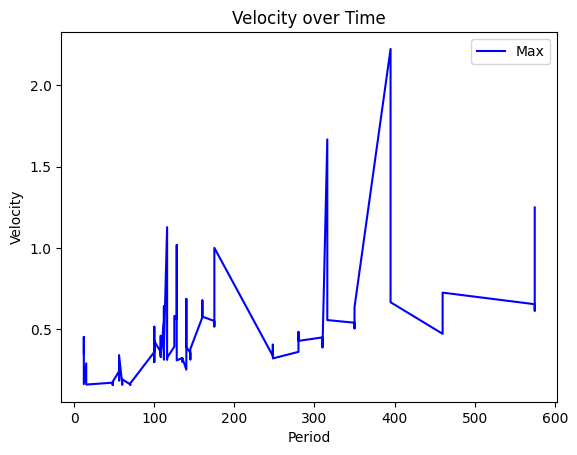

In [41]:
# Vẽ đồ thị đường và đặt màu sắc và chú thích
execution_time_df_sorted = execution_time_df.sort_values('velocity')
plt.plot(execution_time_df_sorted["velocity"], execution_time_df_sorted["execution_time_k_mean"], color="blue", label="Max")
# plt.plot(execution_time_df_sorted["velocity"], execution_time_df_sorted["execution_time_Agglomerative"], color="green", label="Min")

# Thiết lập tiêu đề, nhãn trục x và trục y
plt.title("Velocity over Time")
plt.xlabel("Period")
plt.ylabel("Velocity")

# Hiển thị chú thích (legend)
plt.legend()

# Hiển thị đồ thị
plt.show()


In [212]:
velocity_k_mean_result.groupby(["velocity_label"]).agg({"segment_id":["unique","count"], "tomtom_velocity":["max","min"], "duration_velocity":["max","min"]})

segment_id       tomtom_velocity      \
                               unique count             max min   
velocity_label                                                    
0               [36520, 36519, 26792]     3              43  43   
1               [36520, 36519, 26792]     6              33  33   
2               [36520, 36519, 26792]     3              28  28   

               duration_velocity      
                             max min  
velocity_label                        
0                              9   9  
1                              2   2  
2                              2   2

In [178]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import fowlkes_mallows_score
kmeans_labels = velocity_k_mean_label
hierarchical_labels = velocity_Agglomerative_label
# assume kmeans_labels and hierarchical_labels are the cluster labels obtained from k-means and hierarchical clustering, respectively
ari = adjusted_rand_score(kmeans_labels, hierarchical_labels)
nmi = normalized_mutual_info_score(kmeans_labels, hierarchical_labels)
fmi = fowlkes_mallows_score(kmeans_labels, hierarchical_labels)

print("Adjusted Rand Index: ", ari)
print("Normalized Mutual Information: ", nmi)
print("Fowlkes-Mallows Index: ", fmi)


Adjusted Rand Index:  0.9709750095269414
Normalized Mutual Information:  0.9766647383283826
Fowlkes-Mallows Index:  0.9760759521017628


(316, 2)


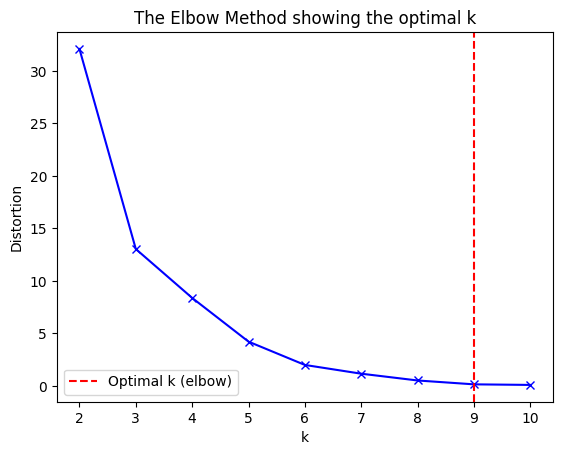

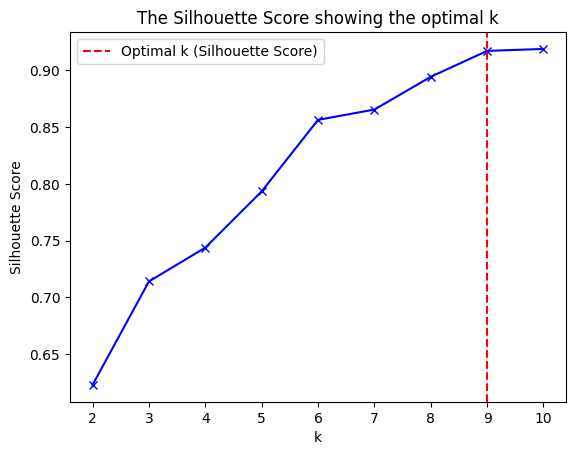

(316, 2)


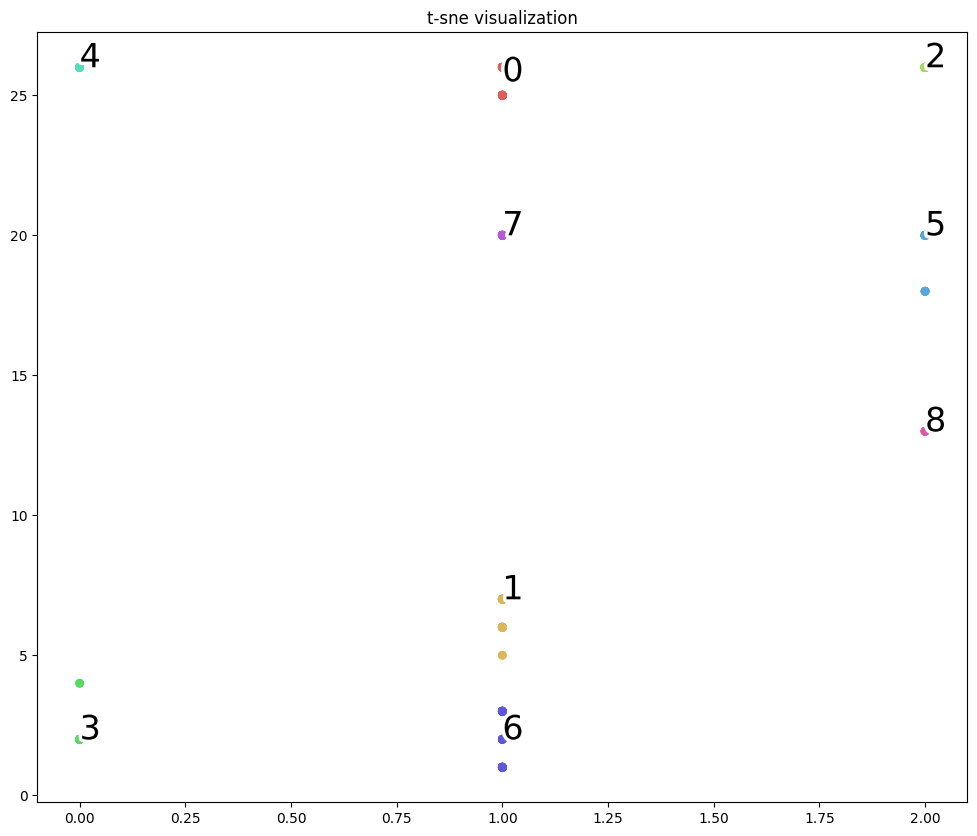

In [179]:
cluster_colums = ['base_LOS', 'duration_LOS']
new_column_name = 'base_LOS_label'
base_LOS_k_mean_result, base_LOS_k_mean_label = get_results(parammeters, total_df, cluster_colums, new_column_name)

In [180]:
base_LOS_k_mean_result.groupby(["base_LOS_label"]).agg({"segment_id":["unique","count"], "base_LOS_label":["unique","count"], "duration_velocity":["max","min"]})

segment_id        \
                                                           unique count   
base_LOS_label                                                            
0               [49614, 35897, 84162, 84115, 35898, 84164, 841...    40   
1               [73119, 73120, 73121, 73122, 73123, 73124, 731...    53   
2               [33639, 33638, 35761, 29731, 29909, 35762, 297...    68   
3               [49614, 35897, 84162, 84115, 35898, 84164, 841...    22   
4               [22132, 22133, 73119, 73120, 73121, 73122, 731...    22   
5               [33639, 33638, 35761, 29731, 29909, 35762, 297...    37   
6               [49614, 35897, 84162, 84115, 35898, 84164, 841...    48   
7               [73119, 73120, 73121, 73122, 73123, 73124, 731...    20   
8                      [29863, 29861, 29865, 29864, 29862, 29866]     6   

               base_LOS_label       duration_velocity      
                       unique count               max min  
base_LOS_label                                             
0                         [0]    40                 3   1  
1                         [1]    53                 2   1  
2                         [2]    68                 2   1  
3                         [3]    22                 2   1  
4                         [4]    22                26   1  
5                         [5]    37                 1   1  
6                         [6]    48                 2   1  
7                         [7]    20                 1   1  
8                         [8]     6                 1   1

/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


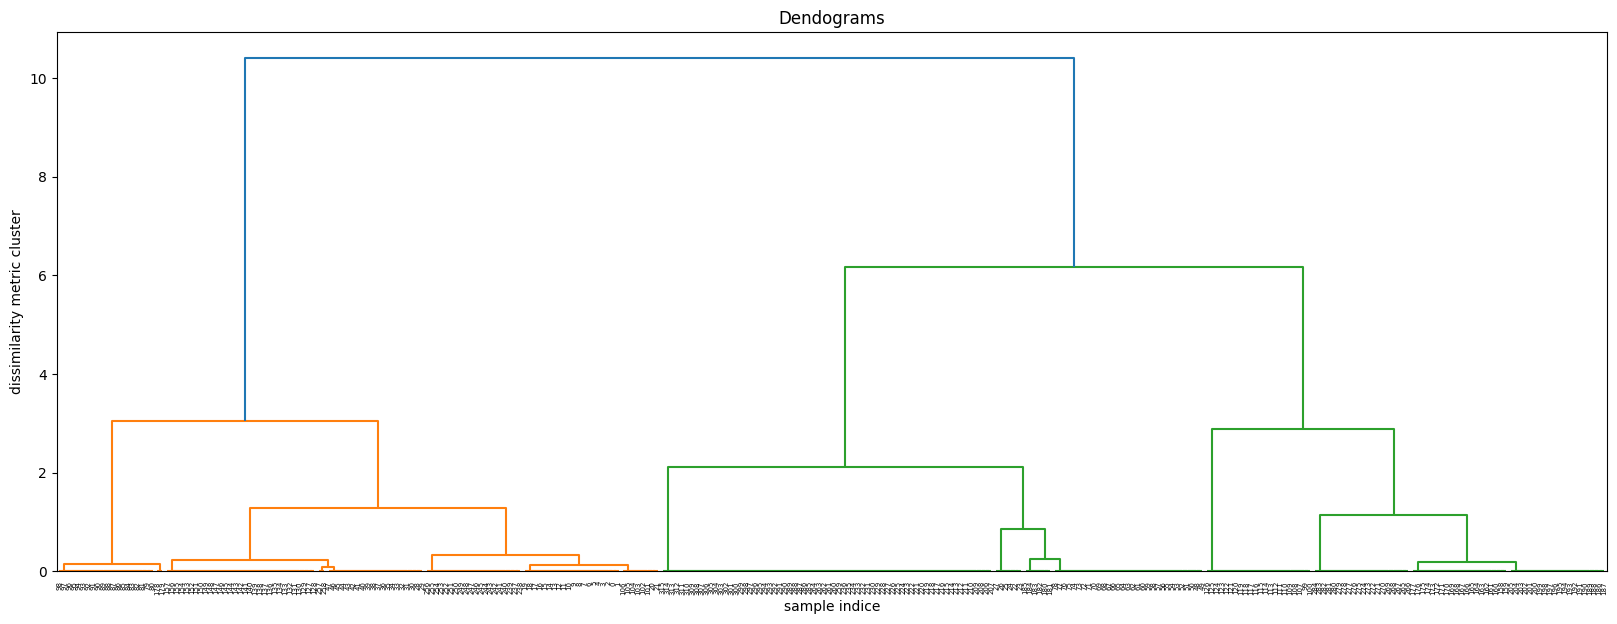

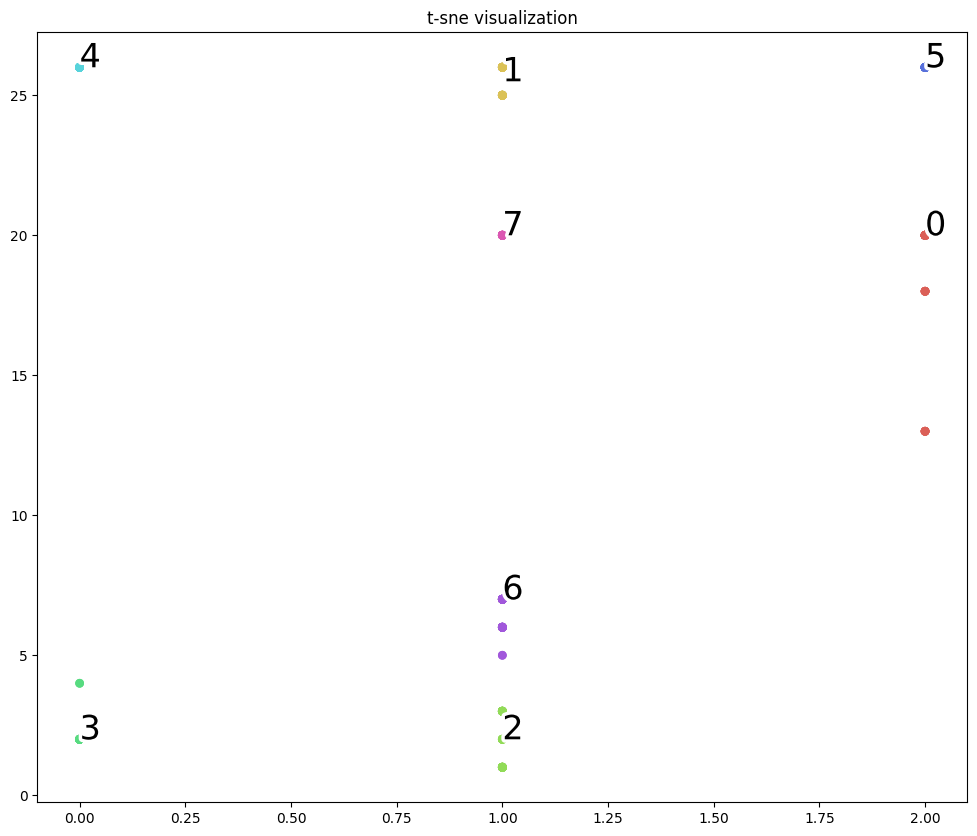

In [181]:
LOS_Agglomerative_result, LOS_Agglomerative_label = get_results_with_Agglomerative(parammeters, total_df, 8, cluster_colums, new_column_name)

In [173]:
base_LOS_k_mean_result.groupby(["segment_id"]).agg({"base_LOS_label":["unique","count"]})

base_LOS_label      
                   unique count
segment_id                     
8720            [1, 4, 2]     5
8721            [1, 4, 2]     5
8722            [1, 4, 2]     5
8723            [1, 4, 2]     5
8724            [1, 4, 2]     5
...                   ...   ...
79316                 [0]     5
81587           [5, 1, 8]     5
81588           [5, 1, 8]     5
81597           [5, 1, 8]     5
81598           [5, 1, 8]     5

[152 rows x 2 columns]

### các quận lân cận, vào 1 thời điểm cụ thể

In [26]:
parammeters = {
    "period": ["period_16_55"],
    "weekday": [1],
    "district": ["Quận Tân Bình", "Quận 10", "Quận Tân Phú"],
#     "is_morning": [1]
}

(608, 2)


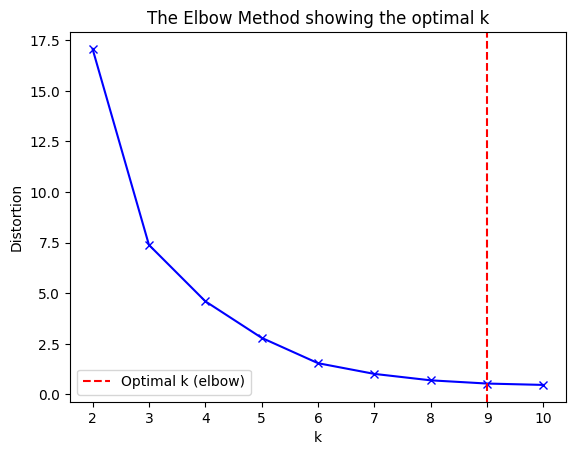

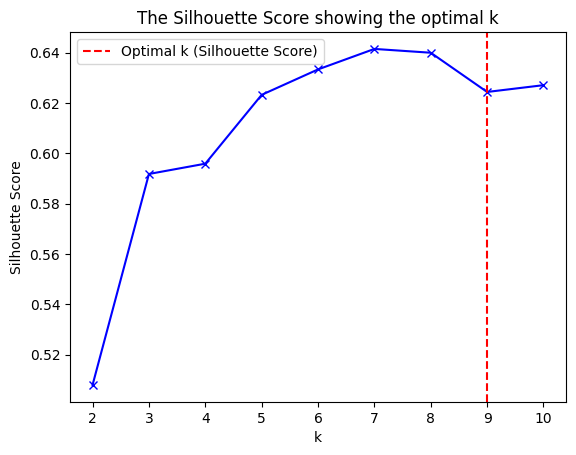

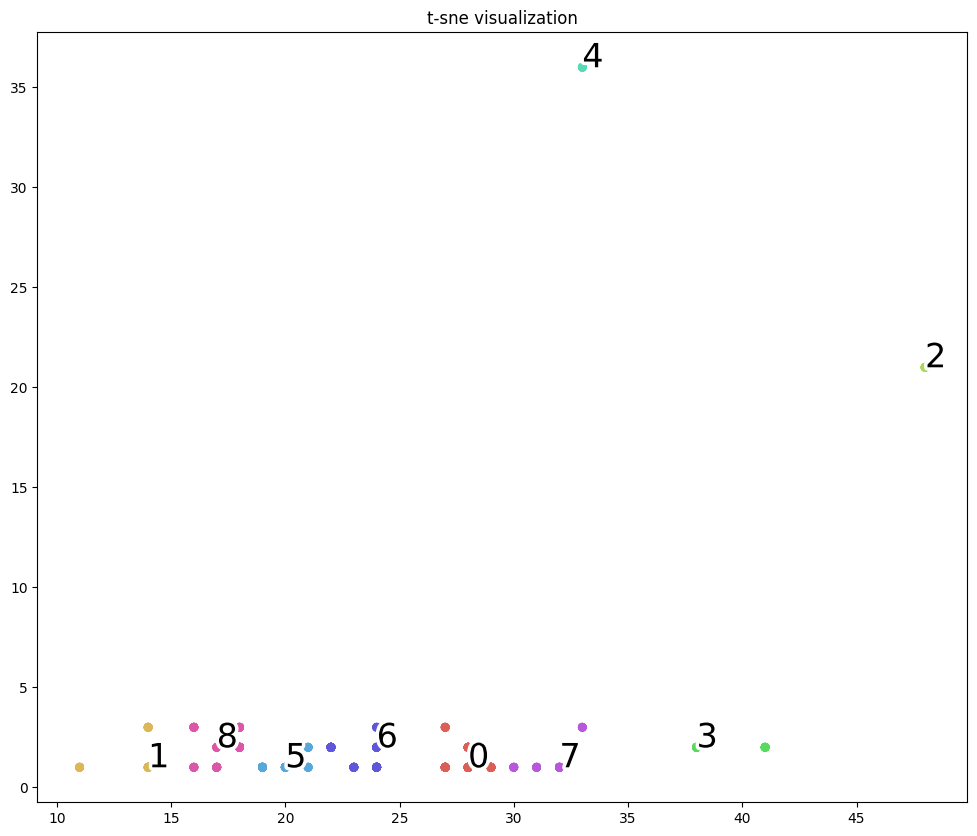

In [27]:
k_mean_result = get_results(parammeters, total_df)

In [114]:
a = k_mean_result.groupby(['segment_id']).agg({"tomtom_velocity":["std", "var"], "duration_velocity":["std", "var"]})
a

tomtom_velocity            duration_velocity      
                       std        var               std   var
segment_id                                                   
12479             5.196152  27.000000               0.5  0.25
12480             5.196152  27.000000               0.5  0.25
16646             2.217356   4.916667               0.0  0.00
16647             2.217356   4.916667               0.0  0.00
16648             2.217356   4.916667               0.0  0.00
...                    ...        ...               ...   ...
84118             5.196152  27.000000               0.5  0.25
84161             5.196152  27.000000               0.5  0.25
84162             5.196152  27.000000               0.5  0.25
84163             5.196152  27.000000               0.5  0.25
84164             5.196152  27.000000               0.5  0.25

[79 rows x 4 columns]

In [115]:
k_mean_result.head(5)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration_velocity,duration_LOS,velocity_label
22,period_16_55,49614,2023-05-16,1,30,1,0,0,27,Thành phố Thủ Đức,10.792465,106.752099,0,1,3,0
23,period_16_55,35897,2023-05-16,1,30,1,0,0,27,Thành phố Thủ Đức,10.792428,106.752003,0,1,3,0
24,period_16_55,84162,2023-05-16,1,30,1,0,0,27,Thành phố Thủ Đức,10.792415,106.752036,0,1,3,0
25,period_16_55,84115,2023-05-16,1,30,1,0,0,27,Thành phố Thủ Đức,10.792446,106.751940,0,1,3,0
26,period_16_55,35898,2023-05-16,1,30,1,0,0,27,Thành phố Thủ Đức,10.792796,106.752073,0,1,3,0


In [116]:
a = k_mean_result.groupby(['segment_id']).agg({"base_LOS":["std", "var"], "duration_LOS":["std", "var"]})
a

base_LOS       duration_LOS            
                std   var          std         var
segment_id                                        
12479           0.5  0.25    11.528949  132.916667
12480           0.5  0.25    11.528949  132.916667
16646           0.5  0.25     8.958236   80.250000
16647           0.5  0.25     8.958236   80.250000
16648           0.5  0.25     8.958236   80.250000
...             ...   ...          ...         ...
84118           0.5  0.25    11.528949  132.916667
84161           0.5  0.25    11.528949  132.916667
84162           0.5  0.25    11.528949  132.916667
84163           0.5  0.25    11.528949  132.916667
84164           0.5  0.25    11.528949  132.916667

[79 rows x 4 columns]

In [75]:
a = k_mean_result.groupby(["label"]).agg({"segment_id":["unique","count"], "tomtom_velocity":["max","min","mean", "median"], "duration":["max","min", "mean", "median"]})

In [89]:
k_mean_result.head(5)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration,velocity_label
22,period_16_55,49614,2023-05-16,1,30,B,0,0,27,Thành phố Thủ Đức,10.792465,106.752099,0,1,0
23,period_16_55,35897,2023-05-16,1,30,B,0,0,27,Thành phố Thủ Đức,10.792428,106.752003,0,1,0
24,period_16_55,84162,2023-05-16,1,30,B,0,0,27,Thành phố Thủ Đức,10.792415,106.752036,0,1,0
25,period_16_55,84115,2023-05-16,1,30,B,0,0,27,Thành phố Thủ Đức,10.792446,106.751940,0,1,0
26,period_16_55,35898,2023-05-16,1,30,B,0,0,27,Thành phố Thủ Đức,10.792796,106.752073,0,1,0


In [117]:
b = k_mean_result.groupby(["segment_id"]).agg({"velocity_label":["unique","count"]})
b

velocity_label      
                   unique count
segment_id                     
12479           [0, 8, 3]     4
12480           [0, 8, 3]     4
16646           [5, 3, 7]     4
16647           [5, 3, 7]     4
16648           [5, 3, 7]     4
...                   ...   ...
84118           [0, 8, 3]     4
84161           [0, 8, 3]     4
84162           [0, 8, 3]     4
84163           [0, 8, 3]     4
84164           [0, 8, 3]     4

[79 rows x 2 columns]

In [78]:
a

segment_id        \
                                                  unique count   
label                                                            
0      [31447, 31126, 31127, 31128, 31129, 31130, 311...   177   
1      [31154, 31181, 36509, 31180, 31312, 31153, 423...    46   
2      [52050, 52049, 49701, 49702, 81598, 81597, 815...     9   
3      [42436, 31201, 42435, 31200, 42426, 33185, 424...    31   
4             [72857, 44481, 72858, 44516, 44482, 44515]     6   
5      [19576, 30917, 72758, 19574, 19577, 42822, 727...    68   
6      [42955, 42957, 8723, 8722, 8721, 8720, 42956, ...   135   
7      [52050, 52049, 49701, 49702, 81598, 81597, 815...    42   
8      [41330, 39577, 41285, 33265, 41286, 33264, 581...    94   

      tomtom_velocity                       duration                        
                  max min       mean median      max min       mean median  
label                                                                       
0                  29  27  27.920904   28.0        3   1   1.237288    1.0  
1                  14  11  13.217391   14.0        3   1   1.608696    1.0  
2                  48  48  48.000000   48.0       21  21  21.000000   21.0  
3                  41  38  39.161290   38.0        2   2   2.000000    2.0  
4                  33  33  33.000000   33.0       36  36  36.000000   36.0  
5                  21  19  19.794118   20.0        2   1   1.132353    1.0  
6                  24  22  23.207407   24.0        3   1   1.555556    2.0  
7                  33  30  31.500000   32.0        3   1   1.285714    1.0  
8                  18  16  17.234043   17.0        3   1   1.936170    2.0

In [79]:
len(a["segment_id"]["unique"][0])

91

In [38]:
a.segment_id.unique.values[0]

array([31447, 31126, 31127, 31128, 31129, 31130, 31131, 31132, 31282,
       31283, 31284, 31285, 31286, 31287, 31288, 31289, 31290, 31291,
       31451, 19576, 30917, 72758, 19574, 19577, 42822, 72757, 30918,
       19575, 42821, 35227, 35229, 19596, 19595, 35226, 35228, 42743,
       42742, 42744, 31154, 31181, 36509, 31180, 31312, 31153, 42324,
       31155, 31179, 31311, 31166, 31167, 31310, 31165, 36296, 41416,
       41414, 39573, 36330, 39574, 41415, 41413, 64931, 42955, 42957,
        8723,  8722,  8721,  8720, 42956, 42958, 60431, 60429, 71374,
       71373,  8725, 42881,  8724, 42953, 60432, 60430, 42954, 42883,
       42882, 71371, 42884, 71372, 72857, 44481, 72858, 44516, 44482,
       44515])

In [56]:
a["tomtom_velocity"].shape[0]

9

In [42]:
test_k_mean_result = k_mean_result.copy()

In [64]:
columns1 = ["tomtom_velocity", "duration"]
columns2 = ["mean", "median"]
for i in columns1:
    k_label = a[i].shape[0]
    for j in columns2:
        new_columns_name = f'predict_{j}_{i}'
        test_k_mean_result[new_columns_name] = [-1]*tes_k_mean_result.shape[0]
        for index in range(k_label):
            test_k_mean_result.loc[test_k_mean_result.segment_id.isin(a.segment_id.unique.values[index]), new_columns_name]= a[i][j][index]
            if index == 4:
                print(a.segment_id.unique.values[index])
                print(f"{i} {j} {a[i][j][index]}")

[72857 44481 72858 44516 44482 44515]
tomtom_velocity mean 33.0
[72857 44481 72858 44516 44482 44515]
tomtom_velocity median 33.0
[72857 44481 72858 44516 44482 44515]
duration mean 36.0
[72857 44481 72858 44516 44482 44515]
duration median 36.0


In [67]:
test_k_mean_result.head(5)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration,label,mean_predict_velocity,predict_mean_tomtom_velocity,predict_median_tomtom_velocity,predict_mean_duration,predict_median_duration
42,period_16_55,52050,2023-05-16,1,30,B,0,0,27,Quận Tân Bình,10.866684,106.791497,0,1,7,-1,31.5,32,1.285714,1
43,period_16_55,52049,2023-05-16,1,30,B,0,0,27,Quận Tân Bình,10.866583,106.791736,0,1,7,-1,31.5,32,1.285714,1
44,period_16_55,49701,2023-05-16,1,30,B,0,0,27,Quận Tân Bình,10.866632,106.791362,0,1,7,-1,31.5,32,1.285714,1
45,period_16_55,49702,2023-05-16,1,30,B,0,0,27,Quận Tân Bình,10.866538,106.791586,0,1,7,-1,31.5,32,1.285714,1
46,period_16_55,81598,2023-05-16,1,30,B,0,0,27,Quận Tân Bình,10.866806,106.791411,0,1,7,-1,31.5,32,1.285714,1


In [68]:
print(test_k_mean_result.loc[test_k_mean_result.segment_id.isin(a.segment_id.unique.values[4])]["predict_median_tomtom_velocity"])
print("--------------")

88    32
89    32
90    32
91    32
92    32
93    32
88    32
89    32
90    32
91    32
92    32
93    32
88    32
89    32
90    32
91    32
92    32
93    32
88    32
89    32
90    32
91    32
92    32
93    32
Name: predict_median_tomtom_velocity, dtype: int64
--------------


In [61]:
test_k_mean_result.predict_median_tomtom_velocity.value_counts()

24    228
17    208
32     96
38     76
Name: predict_median_tomtom_velocity, dtype: int64

In [47]:
test_k_mean_result['mean_predict_velocity'] = [-1]*tes_k_mean_result.shape[0]
test_k_mean_result.loc[test_k_mean_result.segment_id.isin(a.segment_id.unique.values[0]), "mean_predict_velocity"] = 23

In [50]:
test_k_mean_result.mean_predict_velocity.value_counts()

 23    364
-1     244
Name: mean_predict_velocity, dtype: int64

In [38]:
a = get_period_df(parammeters, total_df)

In [42]:
def processing_data2(TRAIN_DIR):
    # TRAIN_DIR = os.path.join('.', 'is_hot_tomtom_segment_status3')
    csv_file_list = os.listdir(TRAIN_DIR)
    total_df = pd.DataFrame()
    for csv_file in csv_file_list:
        temp_df = pd.read_csv(os.path.join(TRAIN_DIR, csv_file), index_col=0)
        total_df = pd.concat([total_df, temp_df])

    label_encoder = LabelEncoder()
    # total_df['base_LOS']= label_encoder.fit_transform(total_df['base_LOS'])
    total_df['isHot'] = label_encoder.fit_transform(total_df['isHot'])
    total_df['weather'] = label_encoder.fit_transform(total_df['weather'])

    return total_df

In [43]:
TRAIN_DIR2 = './is_hot_tomtom_segment_status_with_velocity'
df1 = processing_data2(TRAIN_DIR2)

In [46]:
TRAIN_DIR3 = './result_df2/'
df2 = processing_data2(TRAIN_DIR3)

In [45]:
df1.district.unique()

array(['quan_go_vap', 'huyen_binh_chanh', 'quan_2', 'quan_binh_tan',
       'quan_12', 'quan_tan_phu', 'quan_5', 'quan_tan_binh', 'quan_7',
       'quan_9', 'quan_thu_duc', 'quan_6', 'quan_1', 'quan_4', 'quan_10',
       'huyen_hoc_mon'], dtype=object)

In [47]:
df2.district.unique()

array(['Quận 10', 'Quận Tân Bình', 'Quận 3', 'Quận 11', 'Quận 1'],
      dtype=object)

In [48]:
df3 = pd.read_csv('./selections_points.csv', index_col=0)

In [49]:
df3.district.unique()

array(['quan_go_vap', 'huyen_binh_chanh', 'quan_2', 'quan_binh_tan',
       'quan_12', 'quan_tan_phu', 'quan_5', 'quan_tan_binh', 'quan_7',
       'quan_9', 'quan_thu_duc', 'quan_6', 'quan_1', 'quan_4', 'quan_10',
       'huyen_hoc_mon', 'quan_3', 'quan_11', 'quan_phu_nhuan',
       'Huyện Bình Chánh', 'Quận Gò Vấp', 'Huyện Hóc Môn', 'Quận 8',
       'Quận Phú Nhuận', 'Quận 11', 'Thành phố Thủ Đức', 'Quận Tân Bình',
       'Quận Bình Tân', 'Quận 12', 'Quận Bình Thạnh', 'Quận 7', 'Quận 3',
       'Quận 1', 'Quận 4', 'Quận 6', 'Quận Tân Phú', 'Quận 5', 'Quận 10'],
      dtype=object)

In [63]:
district_dict = {
    'quan_go_vap': 'Quận Gò Vấp',
    'huyen_binh_chanh': 'Huyện Bình Chánh',
    'quan_2': 'Thành phố Thủ Đức',
    'quan_binh_tan': 'Quận Tân Bình',
    'quan_12': 'Quận 12',
    'quan_tan_phu': 'Quận Tân Phú',
    'quan_5': 'Quận 5',
    'quan_tan_binh': 'Quận Tân Bình',
    'quan_7' : 'Quận 7',
    'quan_9': 'Thành phố Thủ Đức',
    'quan_thu_duc': 'Thành phố Thủ Đức',
    'quan_6': 'Quận 6',
    'quan_1': 'Quận 1',
    'quan_4': 'Quận 4',
    'quan_10': 'Quận 10',
    'huyen_hoc_mon': 'Huyện Hóc Môn'
}

In [65]:
for item_path in os.listdir(TRAIN_DIR2):
    temp_df = pd.read_csv(os.path.join(TRAIN_DIR2, item_path), index_col=0)
    for item_value in temp_df.district.unique():
        condition = temp_df.district == item_value
        temp_df.loc[condition, 'district'] = district_dict[item_value]
    temp_df.to_csv(os.path.join("IS_HOT_TOMTOM", item_path))

In [53]:
test_df = pd.read_csv(os.path.join(TRAIN_DIR2, '2023-04-19.csv'), index_col=0)
item_value = 'quan_go_vap'
condition = test_df.district == item_value
test_df.loc[condition, 'district'] = district_dict[item_value]

In [57]:
item_value = 'quan_go_vap'
condition = test_df.district == item_value
test_df.loc[condition, 'district'] = district_dict[item_value]

In [58]:
test_df.district.unique()

array(['Quận Gò Vấp', 'huyen_binh_chanh', 'quan_2', 'quan_binh_tan',
       'quan_12', 'quan_tan_phu', 'quan_5', 'quan_tan_binh', 'quan_7',
       'quan_9', 'quan_thu_duc', 'quan_6', 'quan_1', 'quan_4', 'quan_10',
       'huyen_hoc_mon'], dtype=object)

In [59]:
test_df.head(5)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration
0,period_19_50,23795,2023-04-19,2,28,C,True,few clouds,27,Quận Gò Vấp,10.830985,106.677322,0,1
1,period_19_50,60703,2023-04-19,2,28,C,True,few clouds,27,Quận Gò Vấp,10.831059,106.677386,0,1
2,period_19_50,23794,2023-04-19,2,28,C,True,few clouds,27,Quận Gò Vấp,10.830916,106.677520,0,1
3,period_19_50,60704,2023-04-19,2,28,C,True,few clouds,27,Quận Gò Vấp,10.830894,106.677499,0,1
4,period_19_50,60538,2023-04-19,2,28,C,True,few clouds,27,Quận Gò Vấp,10.830924,106.677335,0,1


In [180]:
total_df.loc[total_df.duration == 2]

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration,duration2
10,period_19_45,47580,2023-05-13,5,36,A,0,0,27,Huyện Bình Chánh,10.798200,106.724413,0,2,10
11,period_19_45,47581,2023-05-13,5,36,A,0,0,27,Huyện Bình Chánh,10.798522,106.726034,0,2,10
12,period_19_45,47582,2023-05-13,5,36,A,0,0,27,Huyện Bình Chánh,10.798756,106.727212,0,2,10
13,period_19_45,47583,2023-05-13,5,36,A,0,0,27,Huyện Bình Chánh,10.798811,106.727531,0,2,10
14,period_19_45,47584,2023-05-13,5,36,A,0,0,27,Huyện Bình Chánh,10.799026,106.728773,0,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,period_06_25,33186,2023-05-10,2,41,A,0,0,27,Quận Tân Bình,10.800943,106.657571,1,2,10
509,period_06_25,33187,2023-05-10,2,41,A,0,0,27,Quận Tân Bình,10.800866,106.657515,1,2,10
510,period_06_25,33188,2023-05-10,2,41,A,0,0,27,Quận Tân Bình,10.800868,106.657575,1,2,10
511,period_06_25,33190,2023-05-10,2,41,A,0,0,27,Quận Tân Bình,10.800559,106.657655,1,2,10


In [113]:
y = total_df['district'].value_counts().index
x = total_df['district'].value_counts()
xsis = []
ysis = []
for i in range(len(x)):
    xsis.append(x[i])
    ysis.append(y[i])

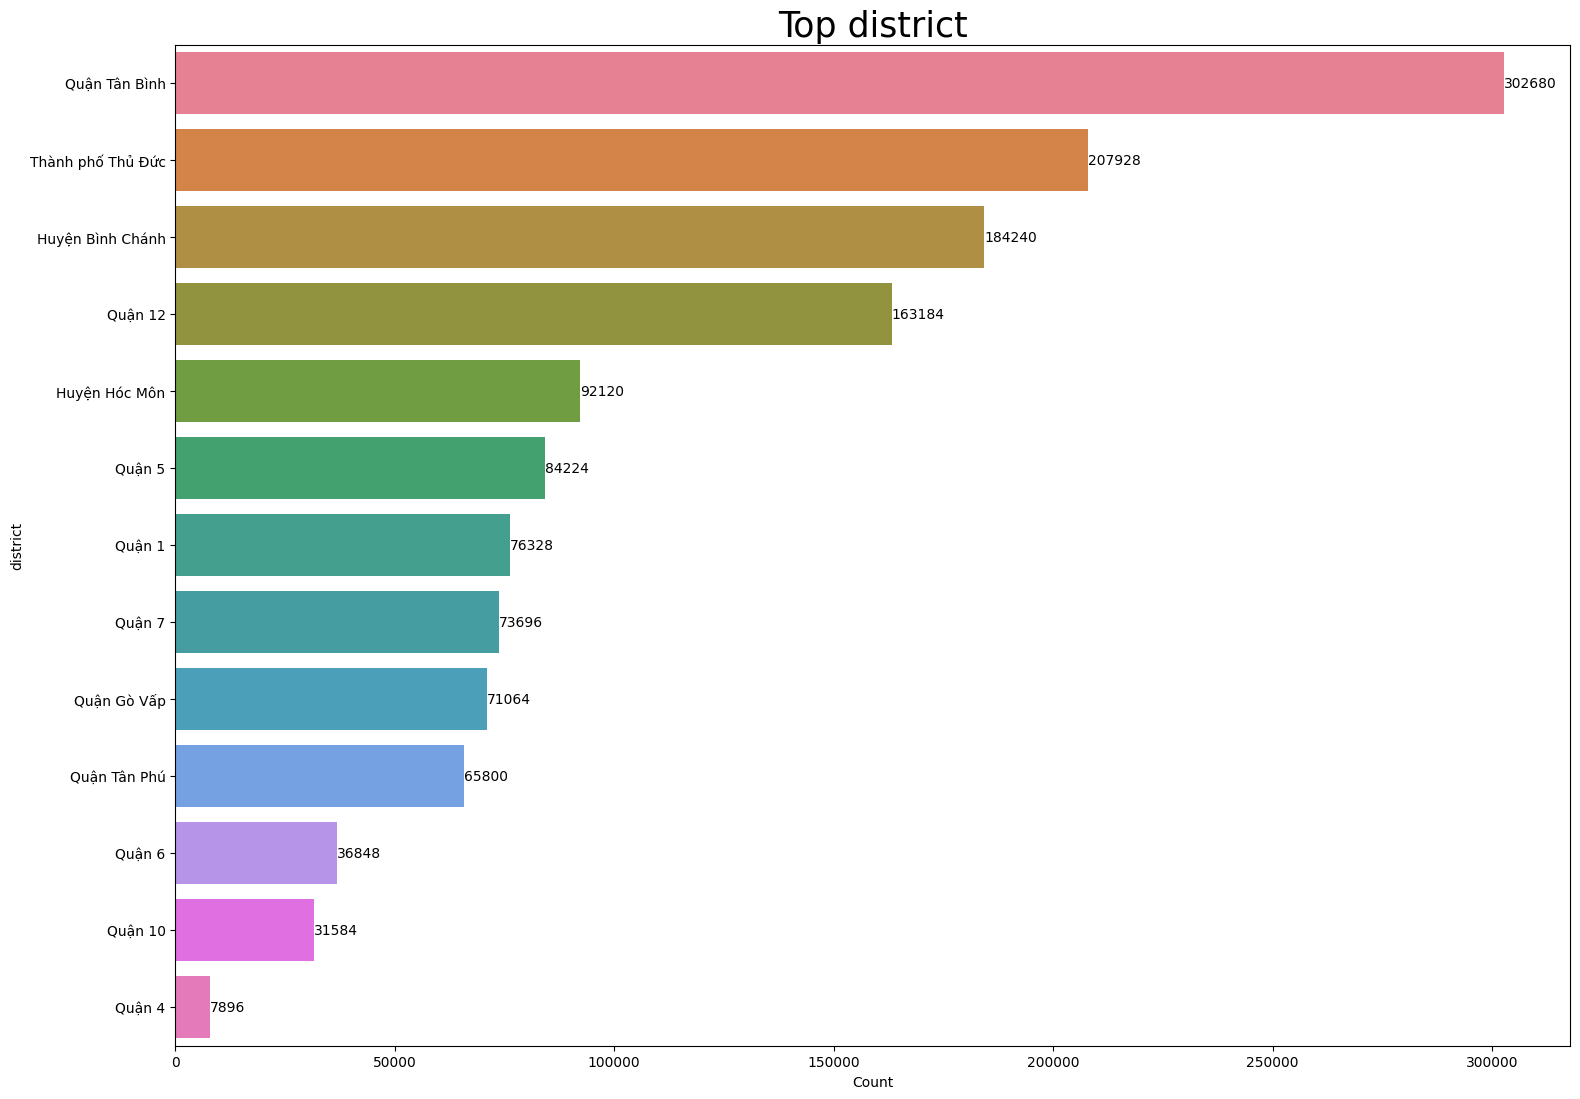

In [116]:
plt.figure(figsize=(18,13))
plt.xlabel("Count")
plt.ylabel("district")

graph = sns.barplot(x = xsis, y = ysis, palette= "husl")
graph.set_title("Top district", fontsize = 25);
for i in range(len(x)):
    plt.text(x=xsis[i], y=i, s=str(xsis[i]), ha='left', va='center')

In [179]:
total_df['district'].value_counts()

Quận Tân Bình        302680
Thành phố Thủ Đức    207928
Huyện Bình Chánh     184240
Quận 12              163184
Huyện Hóc Môn         92120
Quận 5                84224
Quận 1                76328
Quận 7                73696
Quận Gò Vấp           71064
Quận Tân Phú          65800
Quận 6                36848
Quận 10               31584
Quận 4                 7896
Name: district, dtype: int64

/var/folders/b4/c7cgjsq95xq1bp40tnxfz_t00000gn/T/ipykernel_68350/276028799.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  graph = sns.kdeplot(total_df.tomtom_velocity, color="Blue", shade = True)


([<matplotlib.axis.XTick at 0x13d1c0d30>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 0, '35'),
  Text(36, 0, '36'),
  Text(37, 0, '37'),
  Text(38, 0, '38'),
  Text(39, 0, '39'),
  Text(40, 0, '40'),
  Text(41, 0, '41'),
  Text(42, 0, '42'),
  Text(43, 0, '43'),
  Text(44, 0, '44'),
  Text(45, 0, '45'),
  Text(46, 0

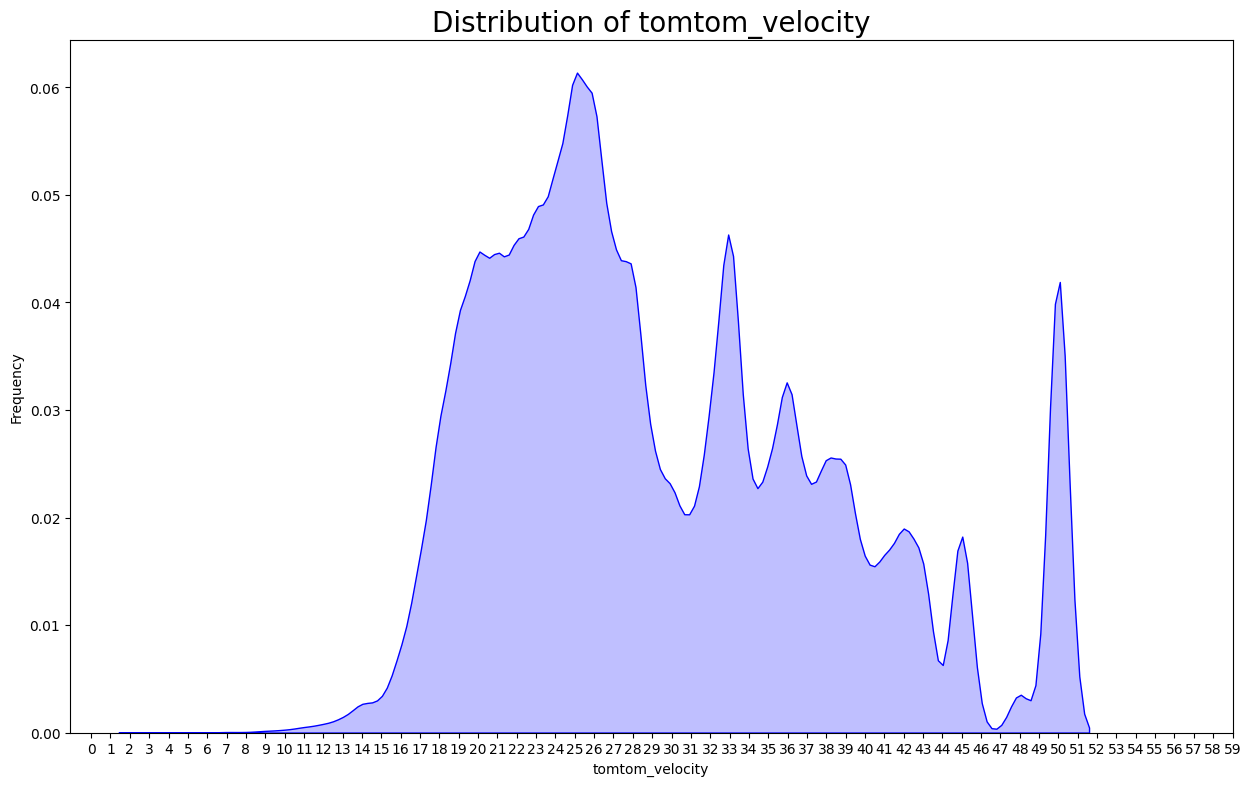

In [97]:
plt.figure(figsize=(15,9))
plt.xlabel("tomtom_velocity")
plt.ylabel("Frequency")
graph = sns.kdeplot(total_df.tomtom_velocity, color="Blue", shade = True)
plt.title('Distribution of tomtom_velocity',size = 20);
# Điều chỉnh độ chia nhỏ nhất (tick) trên trục x
plt.xticks(ticks=range(0, 60, 1))

In [95]:
total_df.tomtom_velocity.value_counts()

25    87177
26    83908
50    78180
33    73992
24    71283
23    67730
28    63566
22    63174
20    63164
21    61483
27    59971
19    54555
36    49725
18    40658
32    40149
39    36490
38    35924
29    35013
45    33418
35    33178
30    32235
37    29602
34    29316
42    27267
31    25767
43    24360
41    22597
17    22171
40    20454
16    10401
48     6453
14     3982
15     3791
44     1872
13     1832
12     1074
11      715
10      344
9       228
46      222
7        85
8        56
47       21
3         9
Name: tomtom_velocity, dtype: int64

In [98]:
total_df["duration2"]= total_df["duration"] *5

/var/folders/b4/c7cgjsq95xq1bp40tnxfz_t00000gn/T/ipykernel_68350/3539565978.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  graph = sns.kdeplot(total_df.duration2, color="Blue", shade = True)


([<matplotlib.axis.XTick at 0x13f063f70>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25'),
  Text(30, 0, '30'),
  Text(35, 0, '35'),
  Text(40, 0, '40'),
  Text(45, 0, '45'),
  Text(50, 0, '50'),
  Text(55, 0, '55'),
  Text(60, 0, '60'),
  Text(65, 0, '65'),
  Text(70, 0, '70'),
  Text(75, 0, '75'),
  Text(80, 0, '80'),
  Text(85, 0, '85'),
  Text(90, 0, '90'),
  Text(95, 0, '95'),
  Text(100, 0, '100'),
  Text(105, 0, '105'),
  Text(110, 0, '110'),
  Text(115, 0, '115'),
  Text(120, 0, '120'),
  Text(125, 0, '125'),
  Text(130, 0, '130'),
  Text(135, 0, '135'),
  Text(140, 0, '140'),
  Text(145, 0, '145'),
  Text(150, 0, '150'),
  Text(155, 0, '155'),
  Text(160, 0, '160'),
  Text(165, 0, '165'),
  Text(170, 0, '170'),
  Text(175, 0, '175'),
  Text(180, 0, '180'),
  Text(185, 0, '185'),
  Text(190, 0, '190'),
  Text(195, 0, '195'),
  Text(200, 0, '200'),
  Text(205, 0, '205'),
  Text(210, 0, '210'),
  Text(215, 0

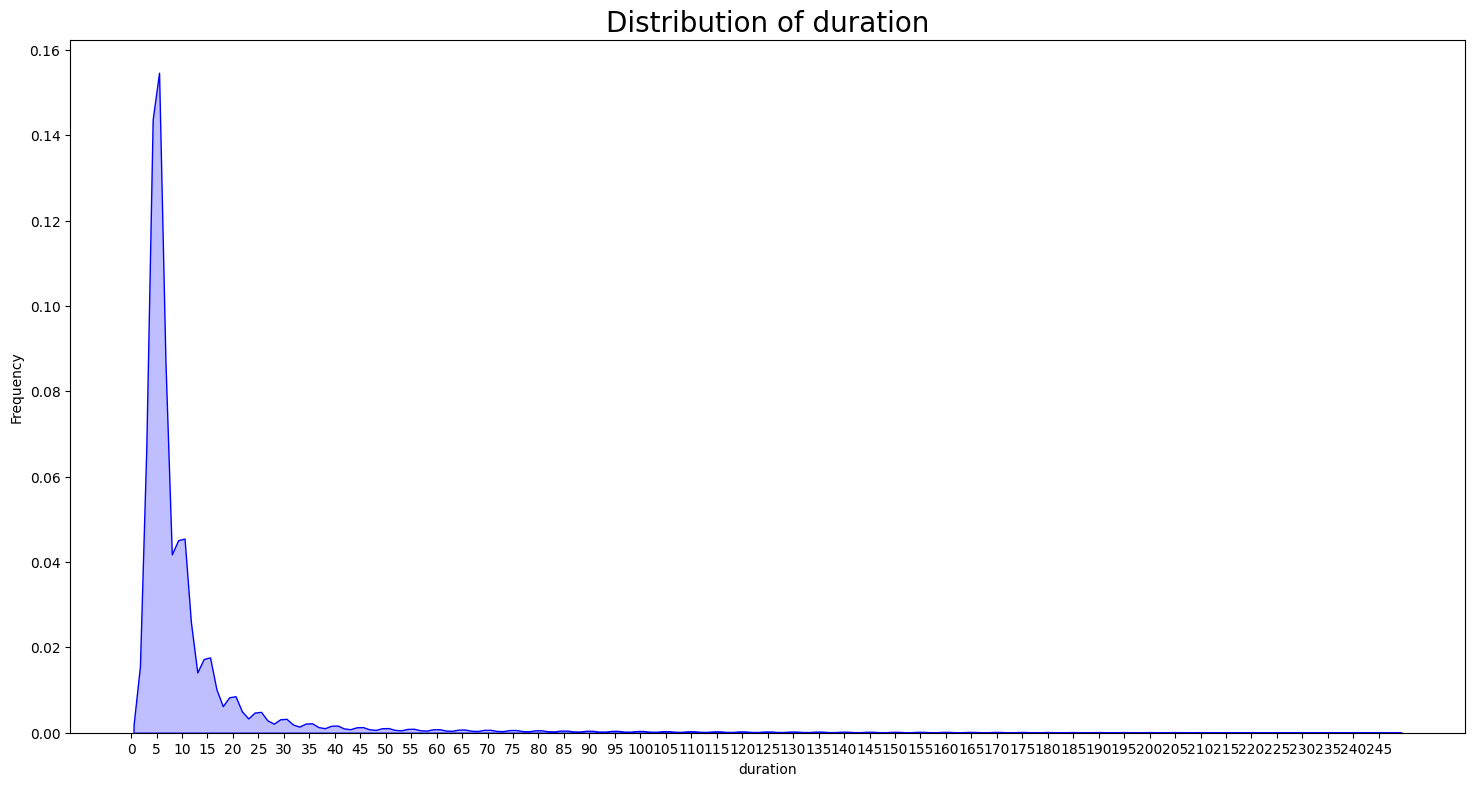

In [105]:
plt.figure(figsize=(18,9))
plt.xlabel("duration")
plt.ylabel("Frequency")
graph = sns.kdeplot(total_df.duration2, color="Blue", shade = True)
plt.title('Distribution of duration',size = 20);
# Điều chỉnh độ chia nhỏ nhất (tick) trên trục x
plt.xticks(ticks=range(0, 250, 5))

In [103]:
total_df.duration2.value_counts()

5      857105
10     251031
15      97515
20      47301
25      27021
30      18023
35      12246
40       9339
45       7316
50       6050
55       5148
60       4606
65       4172
70       3796
75       3558
80       3160
85       2781
90       2544
95       2420
100      2273
105      2001
110      1883
115      1780
120      1663
125      1602
130      1520
135      1433
140      1298
145      1227
150      1156
155      1139
160      1073
165      1044
170      1044
175       970
180       874
185       841
190       821
195       813
200       801
205       795
210       753
215       681
220       672
225       663
230       652
235       641
240       324
245        23
Name: duration2, dtype: int64

In [106]:
x2 = total_df['base_LOS'].value_counts().index
y2 = total_df['base_LOS'].value_counts()

x2sis = []
y2sis = []
for i in range(len(x2)):
    x2sis.append(x2[i])
    y2sis.append(y2[i])

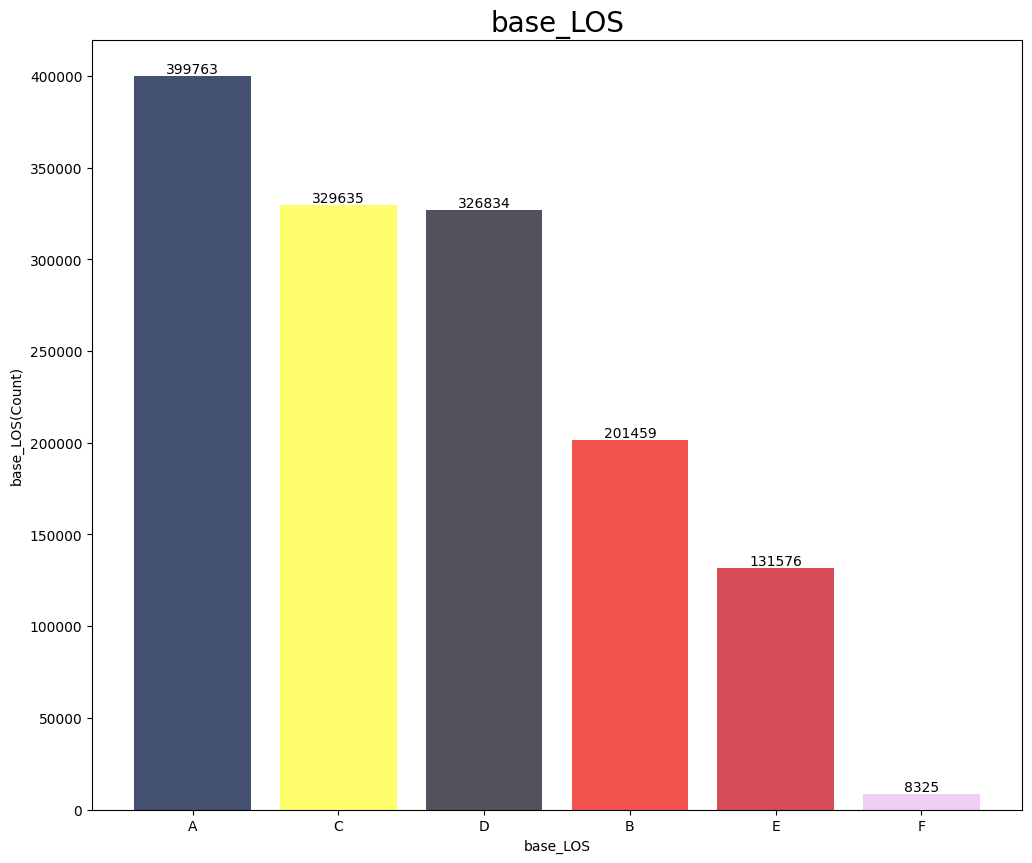

In [119]:
plt.figure(figsize=(12,10))
plt.bar(x2sis,y2sis,width=0.8,color=['#15244C','#FFFF48','#292734','#EF2920','#CD202D','#ECC5F2'], alpha=0.8);
for i in range(len(x2sis)):
    plt.text(x=i, y=y2sis[i], s=str(y2sis[i]), ha='center', va='bottom')
plt.title('base_LOS',size = 20);
plt.ylabel('base_LOS(Count)');
plt.xlabel('base_LOS');

In [110]:
len(total_df.period.value_counts())

99

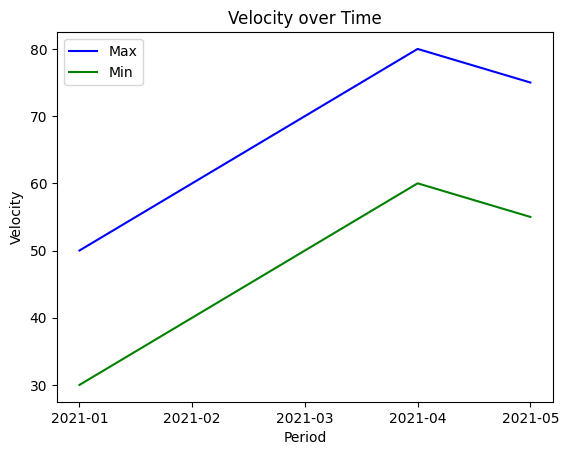

In [120]:
import pandas as pd
import matplotlib.pyplot as plt

# Tạo DataFrame mẫu
data = {
    "period": ["2021-01", "2021-02", "2021-03", "2021-04", "2021-05"],
    "max": [50, 60, 70, 80, 75],
    "min": [30, 40, 50, 60, 55]
}
df = pd.DataFrame(data)

# Vẽ đồ thị đường và đặt màu sắc và chú thích
plt.plot(df["period"], df["max"], color="blue", label="Max")
plt.plot(df["period"], df["min"], color="green", label="Min")

# Thiết lập tiêu đề, nhãn trục x và trục y
plt.title("Velocity over Time")
plt.xlabel("Period")
plt.ylabel("Velocity")

# Hiển thị chú thích (legend)
plt.legend()

# Hiển thị đồ thị
plt.show()


In [121]:
total_df.head(1)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,lat,lng,is_morning,duration,duration2
0,period_19_50,23795,2023-05-13,5,26,C,0,0,27,Quận Gò Vấp,10.830985,106.677322,0,1,5


In [122]:
group_total_df = total_df.groupby(['period']).agg({"tomtom_velocity":["max","min"]})

In [129]:
group_total_df["tomtom_velocity"]["min"].values

array([17, 17, 16, 16, 15, 15, 14, 14, 14, 14, 14, 13, 14, 11, 12, 13, 13,
       11, 11,  9,  9,  9, 12, 13, 10, 11,  7,  7, 12, 14, 11,  8, 10, 13,
       10,  8,  8,  8,  7, 10,  9, 10, 11, 14, 13, 10,  9, 12,  9, 14, 11,
       10,  8, 12, 10, 13, 11, 11, 11, 10,  9, 10, 11,  8, 11,  9, 11, 11,
       10,  9,  9,  7, 10,  9, 11, 11, 10, 10, 11, 10, 10, 10,  9, 10,  9,
       11, 12, 14, 13, 14, 15, 13, 11, 11, 13, 13, 10,  9,  3])

In [124]:
morning_df = total_df.loc[total_df.is_morning == 0]

In [173]:
group_morning_df = morning_df.groupby(['period']).agg({"tomtom_velocity":["max","min"]})


In [175]:
group_morning_df_T = group_morning_df.transpose()
group_morning_df_T

period               period_15_55  period_16_00  period_16_05  period_16_10  \
tomtom_velocity max            50            50            50            50   
                min            11            10             8            12   

period               period_16_15  period_16_20  period_16_25  period_16_30  \
tomtom_velocity max            50            50            50            50   
                min            10            13            11            11   

period               period_16_35  period_16_40  ...  period_19_10  \
tomtom_velocity max            50            50  ...            50   
                min            11            10  ...            14   

period               period_19_15  period_19_20  period_19_25  period_19_30  \
tomtom_velocity max            50            50            50            50   
                min            15            13            11            11   

period               period_19_35  period_19_40  period_19_45  period_19_50  \
tomtom_velocity max            50            50            50            50   
                min            13            13            10             9   

period               period_19_55  
tomtom_velocity max            50  
                min             3  

[2 rows x 49 columns]

In [168]:
period_list = []
for i in group_morning_df["period"]["unique"].values:
    period_list.append(i[0])
print(period_list)

['period_15_55', 'period_16_00', 'period_16_05', 'period_16_10', 'period_16_15', 'period_16_20', 'period_16_25', 'period_16_30', 'period_16_35', 'period_16_40', 'period_16_45', 'period_16_50', 'period_16_55', 'period_17_00', 'period_17_05', 'period_17_10', 'period_17_15', 'period_17_20', 'period_17_25', 'period_17_30', 'period_17_35', 'period_17_40', 'period_17_45', 'period_17_50', 'period_17_55', 'period_18_00', 'period_18_05', 'period_18_10', 'period_18_15', 'period_18_20', 'period_18_25', 'period_18_30', 'period_18_35', 'period_18_40', 'period_18_45', 'period_18_50', 'period_18_55', 'period_19_00', 'period_19_05', 'period_19_10', 'period_19_15', 'period_19_20', 'period_19_25', 'period_19_30', 'period_19_35', 'period_19_40', 'period_19_45', 'period_19_50', 'period_19_55']


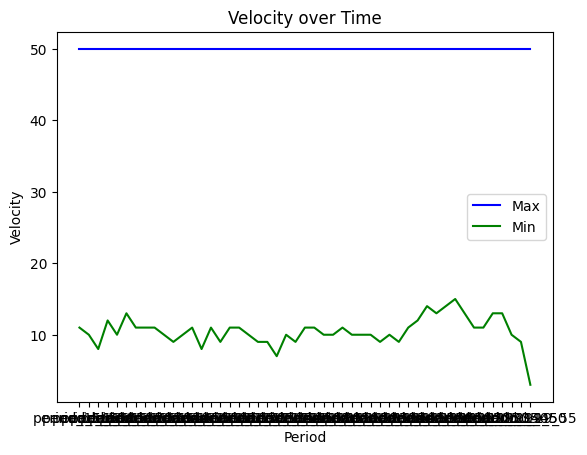

In [169]:
import pandas as pd
import matplotlib.pyplot as plt

# Tạo DataFrame mẫu
data = {
    "period": ["2021-01", "2021-02", "2021-03", "2021-04", "2021-05"],
    "max": [50, 60, 70, 80, 75],
    "min": [30, 40, 50, 60, 55]
}
df = pd.DataFrame(data)
period = []
# Vẽ đồ thị đường và đặt màu sắc và chú thích
plt.plot(period_list, group_morning_df["tomtom_velocity"]["max"].values, color="blue", label="Max")
plt.plot(period_list, group_morning_df["tomtom_velocity"]["min"].values, color="green", label="Min")

# Thiết lập tiêu đề, nhãn trục x và trục y
plt.title("Velocity over Time")
plt.xlabel("Period")
plt.ylabel("Velocity")

# Hiển thị chú thích (legend)
plt.legend()

# Hiển thị đồ thị
plt.show()

In [177]:
total_df.district.value_counts()

Quận Tân Bình        302680
Thành phố Thủ Đức    207928
Huyện Bình Chánh     184240
Quận 12              163184
Huyện Hóc Môn         92120
Quận 5                84224
Quận 1                76328
Quận 7                73696
Quận Gò Vấp           71064
Quận Tân Phú          65800
Quận 6                36848
Quận 10               31584
Quận 4                 7896
Name: district, dtype: int64

In [178]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1397592 entries, 0 to 530
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   period           1397592 non-null  object 
 1   segment_id       1397592 non-null  int64  
 2   date             1397592 non-null  object 
 3   weekday          1397592 non-null  int64  
 4   tomtom_velocity  1397592 non-null  int64  
 5   base_LOS         1397592 non-null  object 
 6   isHot            1397592 non-null  int64  
 7   weather          1397592 non-null  int64  
 8   temperature      1397592 non-null  int64  
 9   district         1397592 non-null  object 
 10  lat              1397592 non-null  float64
 11  lng              1397592 non-null  float64
 12  is_morning       1397592 non-null  int64  
 13  duration         1397592 non-null  int64  
 14  duration2        1397592 non-null  int64  
dtypes: float64(2), int64(9), object(4)
memory usage: 170.6+ MB
